In [3]:
import pandas as pd
import csv
import os
import numpy as np
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import colors as mcolors
from functools import reduce
import re
from sklearn import preprocessing
import collections
from scipy import fftpack, interpolate, stats, integrate

# %matplotlib inline

In [4]:
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, 'Raw data')
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')
Plots_dir = os.path.join(Output_dir, 'Plots')

In [5]:
nodes_file_names = ['May2018_idle.csv' , 'June2018_idle.csv', 'July2018_idle.csv', \
                    'September2018.csv', 'October2018.csv', 'November2018.csv', \
                    'December2018.csv' , 'January2019.csv', 'February2019.csv']
nodes_df_names = [item.split('.')[0] for item in nodes_file_names]
node_df_may = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_May2018_idle.csv'), delimiter=";", header=0, index_col=0 )
node_names = node_df_may.columns.values
nodes_stats_ = 'nodes_stats_'

Drop vs no_drop dfs:

No_drop dataframes contain stats about nodes where the relative error between total_dcenergy and sys_energy (computed through integral) is greater than 5%

In [28]:
# # Read preprocessed data for every node separately for every month
# all_nodes_by_month_dict = {}
# for df_name in nodes_df_names:
#     all_nodes_by_month_dict[df_name] = {}
#     for node in node_names:
#         node_df = data_prep_df[df_name].copy()
#         all_nodes_by_month_dict[df_name][node] = node_df[node_df.nodename == node].copy()

### Read stats with "temp_no_outliers" or "temp_variation"
- "temp_no_outliers" 
        large infrequent (appear in <1e-1 % of cases for each month) variations between successive measurements that happen within are deleted
- "temp_variation" 
        calculated variation of temperature for evey node within a month
        dropped cases when abs(temp) > 100
        

In [4]:
# name_suffix = '_temp_no_outliers'
# _no_outliers = '_no_outliers'

_no_outliers = ''
name_suffix = '_temp_variation'

# name_suffix = ''

In [5]:
# Read preprocessed data
data_prep_df = {}
for df_name in nodes_df_names:
        data_prep_df[df_name] = pd.read_csv( os.path.join( Data_prep_dir, df_name + name_suffix + '.csv'), \
                                             delimiter=";", header=0 )

In [6]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, nodes_stats_ + df_name + name_suffix + '.csv' ), \
                                         delimiter=";", header=0, index_col=0)
    to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_df_dict[df_name].loc['dcenergy_error_percent', :].isna())[0], \
                                     np.where(nodes_df_dict[df_name].loc['dcenergy_error_percent', :] > 5.)[0]))
    to_drop = nodes_df_dict[df_name].iloc[:,to_drop_ix].columns.values
    nodes_df_dict[df_name].drop(columns=to_drop, inplace=True)
    
nodes_no_drop_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_no_drop_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, nodes_stats_ + df_name + name_suffix + '.csv' ), \
                                         delimiter=";", header=0, index_col=0)

In [7]:
nodes_summary_df         = pd.read_csv(os.path.join( Output_dir, \
                                                    'nodes_summary_all_months' + name_suffix + '.csv'), sep=";", index_col=0 )
nodes_summary_no_drop_df = pd.read_csv(os.path.join( Output_dir, \
                                                    'nodes_summary_all_months_no_drop' + name_suffix + '.csv'), sep=";" ) 

In [ ]:
all_nodes_dict = {}
for node in node_names:
    all_nodes_dict[node] = pd.read_csv( os.path.join( Data_prep_dir, \
                                                     'Nodes', \
                                                     'Node_'+str(int(node.split('x')[1])) + node_suffix + '.csv'), \
                                        sep=";", index_col=0 ) 

---------------------
### Data manipulation functions

In [11]:
def drop_nan_inf_cols_by_row_to_plot(df):
    df_output = df.copy()
    
    inf_cols = df_output.loc[:, df_output.columns.to_series()[np.isinf(df_output).any()]]
    df_output.drop(inf_cols, axis=1, inplace=True)
    
    nan_cols = df_output.loc[:, df_output.isna().any()]
    df_output.drop(nan_cols, axis=1, inplace=True)
    return df_output

In [10]:
def extract_mm_YYYY (string):
    year = re.findall(r'\d+', string)[0]
    month = string.split(year)[0]
    return month, year

## Pie-charts with *energy* portions used by CPU, memory and other sources

In [11]:
def plot_energy_cons(data, node, month, year, avg_flag=False, drop_flag=True):
    labels = 'CPU', 'Memory', 'Other'
    data = data.values
    colors = ['lightskyblue', 'lightcoral',  'yellowgreen']# 'gold', 
    
    fig1, ax1 = plt.subplots()
    
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=0)
    
    plt.axis('equal')
    
    save_to = (os.path.join( Plots_dir, 'En_cons_categories_cpu_mem_other', 'Categories_avg_en_' + month + '_' + year ) )
    if not avg_flag:
        plt.title(month + ' ' + year + ', Node '+ node)
        save_to = (os.path.join( Output_dir, 'Plots', 'Node_' + node + '_' + month + '_' + year ) )
    else:
        plt.title(month + ' ' + year)
        
    if drop_flag:
        save_to += '.png'
    else:
        save_to += '_no_drop.png'
    plt.tight_layout()
    fig1.savefig(save_to, dpi=900)
    plt.show()

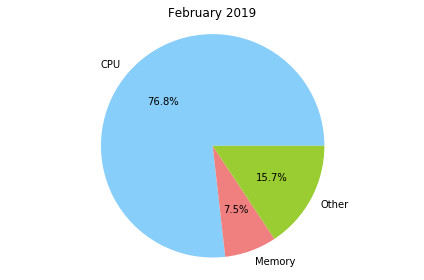

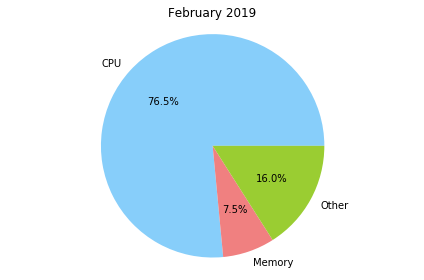

In [9]:
for df_name in nodes_df_names[-1:]:
    year = re.findall(r'\d+', df_name)[0]
    month = df_name.split(year)[0]
    data=nodes_df_dict[df_name].iloc[5:8,:].mean(axis=1)
    plot_energy_cons(data=data, \
                     node='', \
                     month=month, year=year, avg_flag=True)
    no_drop_data = nodes_no_drop_df_dict[df_name].iloc[5:8,:].mean(axis=1)
    if not np.array_equal(no_drop_data.values, data.values):
        energy_category_no_drop = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].iloc[5:8,:])
#         print(energy_category_no_drop.mean(axis=1))
        plot_energy_cons(data=energy_category_no_drop.mean(axis=1), \
                     node='', \
                     month=month, year=year, avg_flag=True, drop_flag=False)

[78.31911634  6.96850411 14.71237955] 100.00000000000001


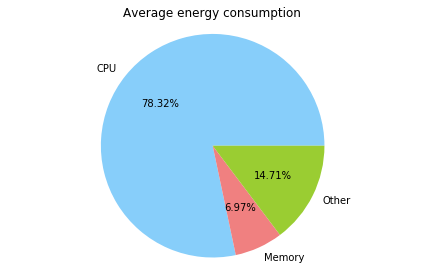

In [10]:
colors = ['lightskyblue', 'lightcoral',  'yellowgreen']
labels = 'CPU', 'Memory', 'Other'
data = nodes_summary_df.\
                    loc[['cpu_en_percent', 'mem_en_percent', 'other_en_percent'], 'avg_all_nodes']
fig1, ax1 = plt.subplots()
print(data.values, data.values.sum())
plt.pie(x=data.values, \
        labels=labels, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.title('Average energy consumption')
plt.tight_layout()
fig1.savefig(os.path.join( Output_dir, 'Plots', \
                          'En_cons_categories_cpu_mem_other', 'Categories_avg_en_cons_all_months.png' ), dpi=900 )
plt.show()

In [19]:
nodes_summary_no_drop_df.loc[['cpu_en_percent', 'mem_en_percent', 'other_en_percent'], 'avg_all_nodes']

cpu_en_percent      77.884699
mem_en_percent       6.954301
other_en_percent    15.161000
Name: avg_all_nodes, dtype: float64

[77.75482821  6.85053654 15.39463525]


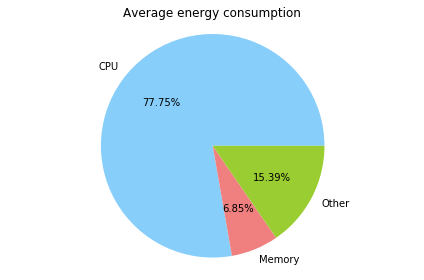

In [20]:
colors = ['lightskyblue', 'lightcoral',  'yellowgreen']
labels = 'CPU', 'Memory', 'Other'
data = pd.read_csv(os.path.join( Output_dir, 'nodes_summary_all_months_no_drop.csv'), \
                                         delimiter=";", header=0, index_col=0).\
                    loc[['cpu_en_percent', 'mem_en_percent', 'other_en_percent'], 'avg_all_nodes']
fig1, ax1 = plt.subplots()
print(data.values)
plt.pie(x=data.values, \
        labels=labels, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.title('Average energy consumption')
plt.tight_layout()
fig1.savefig(os.path.join( Output_dir, 'Plots', \
                          'En_cons_categories_cpu_mem_other', 'Categories_avg_en_cons_all_months_no_drop.png' ), dpi=900 )
plt.show()

## Energy consumption for each node - histogram for each month
- Nodes are sorted by their energy consumption
- Node IDs do not correspond to real node names like 1..cresc6x001. Node IDs are fictionary labels for ease of understanding the graph: 

    $y$ axis - energy consumed by a node during the month mentionted in the title;

    $x$ axis - all the nodes 

### a) Based on dcenergy measurements

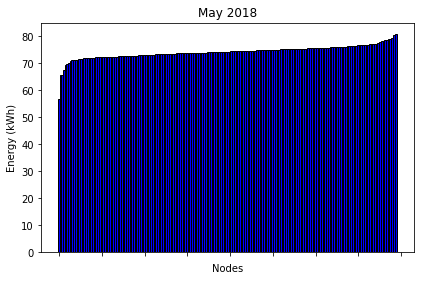

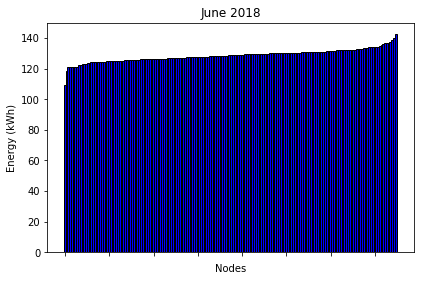

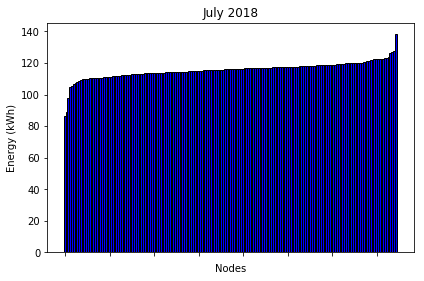

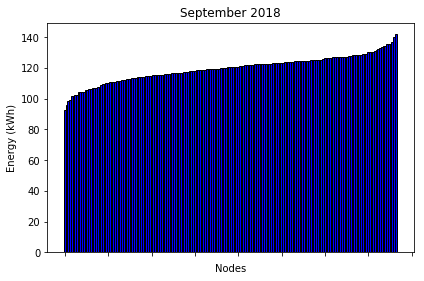

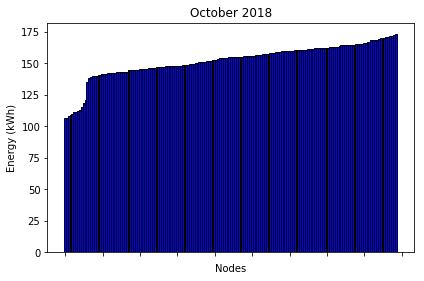

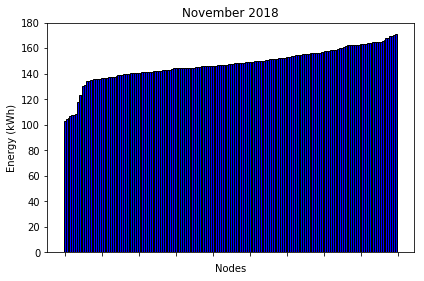

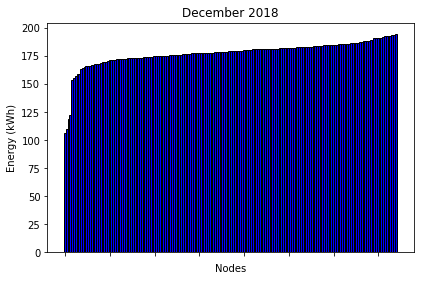

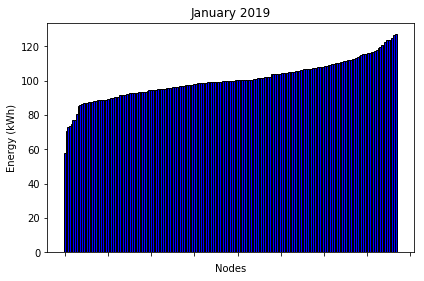

In [9]:
for df_name in nodes_df_names:
    data = nodes_df_dict[df_name].loc['total_dcenergy',:].sort_values(ascending=True)
    fig, ax = plt.subplots()
    N = len(nodes_df_dict[df_name].columns.values)
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='blue', edgecolor='black', width=1.5)#en_exit_jobs_kWh
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    month, year = extract_mm_YYYY(df_name)
    plt.title(month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'En_cons_total', 'En_cons_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

## b) Based on system energy calculation - without dropping nodes, where sys_energy <> dc_energy
Check DC energy graphs for May in the "Preprocessing" file: the problem is in energy meter and not in the power meter.

214


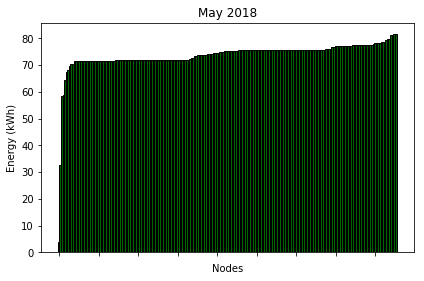

214


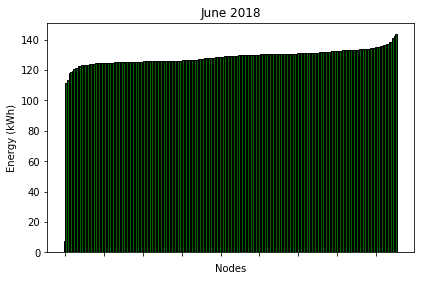

214


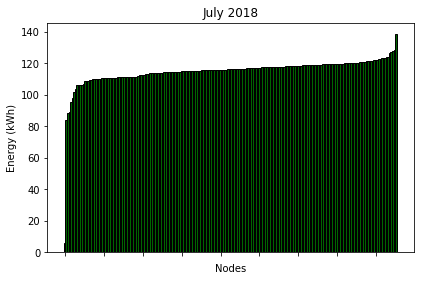

214


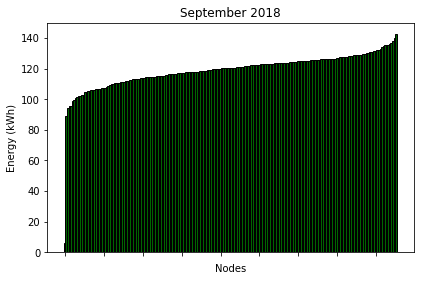

214


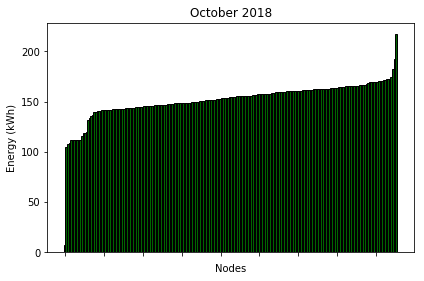

213


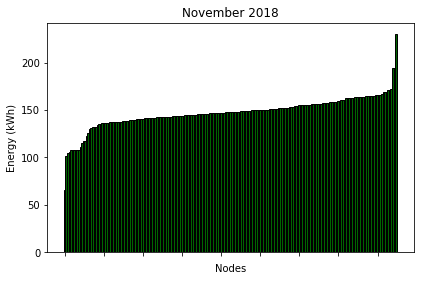

213


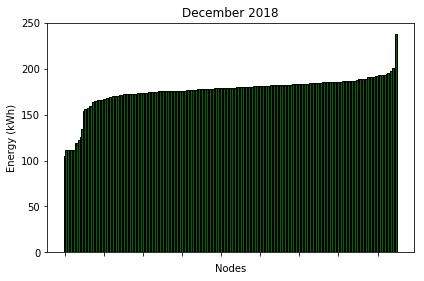

213


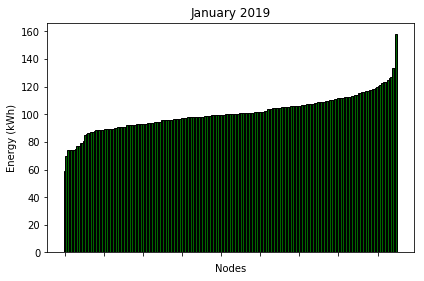

In [10]:
for df_name in nodes_df_names:
    data = nodes_no_drop_df_dict[df_name].loc['sys_energy',:].sort_values(ascending=True)
    data = data[data > 0.]
    fig, ax = plt.subplots()
    N = len(data)
    print(N)
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='darkgreen', edgecolor='black', width=1.5)#en_exit_jobs_kWh
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    
#     plt.xticks([int(re.findall(r'\d+', x)[1]) for x in nodes_no_drop_df_dict[df_name].columns.values][::10], rotation=90)
    month, year = extract_mm_YYYY(df_name)
    plt.title(month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'En_cons_total', 'Sys_cons_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

-----
## Monthly energy consumption of the whole cluster 
### a) Based on dcenergy measurements - uneven data, missing data 

In [31]:
# Sys_energy - from no drop df
energy_by_month = pd.read_csv( os.path.join( Output_dir, 'energy_summary_by_month_no_outiers.csv'), \
                                             delimiter=";", header=0, index_col=0 )
energy_by_month

,total_dcenergy_MWh,total_sys_energy_MWh,idle_energy_MWh,idle_energy_percent_MWh
May2018_idle,14.693,15.761,6.841,43.404
June2018_idle,24.173,27.456,15.864,57.780
July2018_idle,21.624,24.611,9.690,39.371
September2018,22.969,25.461,13.657,53.638
October2018,27.048,32.490,12.582,38.726
November2018,26.540,31.381,12.838,40.908
December2018,33.023,37.567,7.617,20.275
January2019,19.393,21.489,9.163,42.637
February2019,21.274,23.778,14.050,59.088


In [30]:
print(energy_by_month.total_dcenergy_MWh.sum(), energy_by_month.total_sys_energy_MWh.sum())

210.73700000000002 239.994


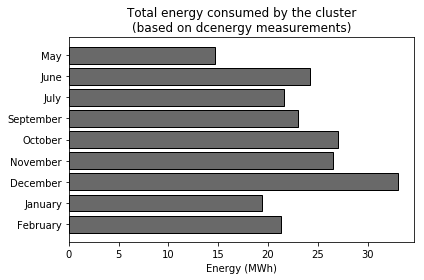

In [32]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, energy_by_month.total_dcenergy_MWh, color='dimgrey', edgecolor='black')#saddlebrown
plt.title('Total energy consumed by the cluster\n(based on dcenergy measurements)')
plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January', 'February'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'energy_cons_by_month_dcenergy.png'),dpi=900)
plt.show()

## Monthly energy consumption of the whole cluster 
### b) Based on sys_power measurements - integral taken over time - more precise as all the nodes are present
However, the sys_power measurements can contain technical sensor uncertainties 

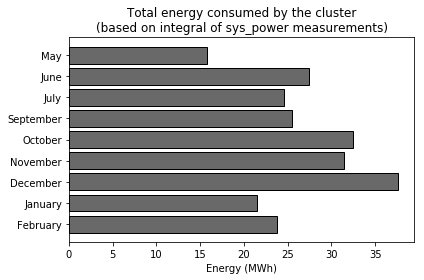

In [33]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, energy_by_month.total_sys_energy_MWh, color='dimgray', edgecolor='black')#saddlebrown

plt.title('Total energy consumed by the cluster\n(based on integral of sys_power measurements)')
plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January', 'February'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'energy_cons_by_month_sys_power_int.png'),dpi=300)
plt.show()

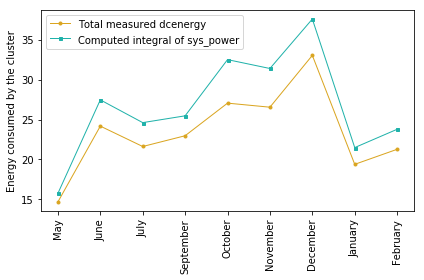

In [34]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, energy_by_month.total_dcenergy_MWh, color='goldenrod', \
              linestyle='-', marker='o',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle=':'

p2 = plt.plot(ind, energy_by_month.total_sys_energy_MWh, color='lightseagreen', \
              linestyle='-', marker='s',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle='-.'
lgd = plt.legend((p1[0], p2[0]), ( 'Total measured dcenergy', 'Computed integral of sys_power' ),\
           loc='upper left')
plt.ylabel('Energy consumed by the cluster')
plt.xticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January', 'February'), rotation=90)
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'Total_en_dcenergy_vs_sys_power_integral.png'), bbox_inches='tight',\
           dpi=1200)
plt.show()

-----
## Temperature profiles


## Exhaust and inlet tempterature taken at average for every node and every month

u'Temperature (℃)')

       Relative_error_l2
exh             0.051359
inlet           0.019853
cpu1            0.036726
cpu2            0.038949


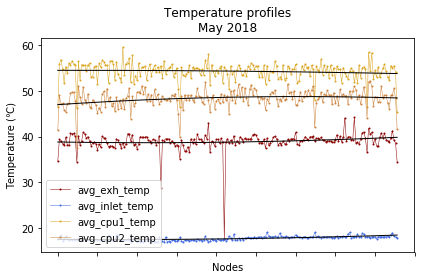

       Relative_error_l2
exh             0.044847
inlet           0.018521
cpu1            0.031298
cpu2            0.030816


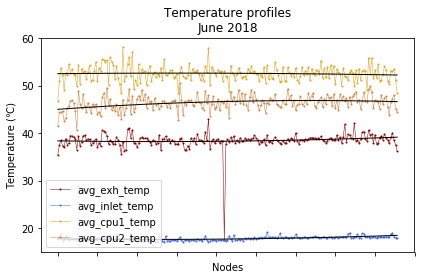

       Relative_error_l2
exh             0.050020
inlet           0.019277
cpu1            0.039104
cpu2            0.041920


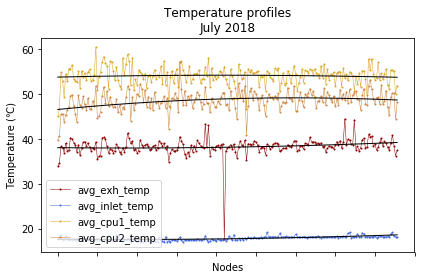

       Relative_error_l2
exh             0.057834
inlet           0.018849
cpu1            0.058946
cpu2            0.060761


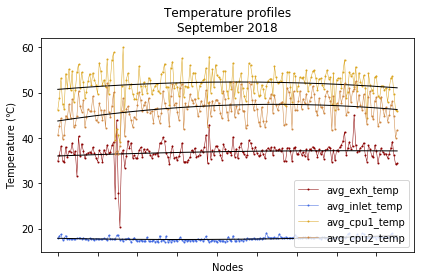

       Relative_error_l2
exh             0.059423
inlet           0.019487
cpu1            0.060723
cpu2            0.059985


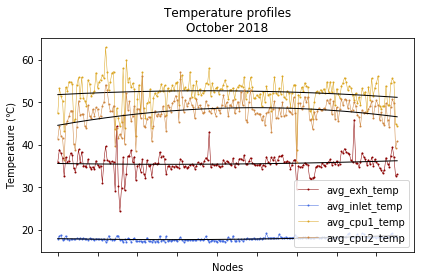

       Relative_error_l2
exh             0.066224
inlet           0.023464
cpu1            0.075509
cpu2            0.071828


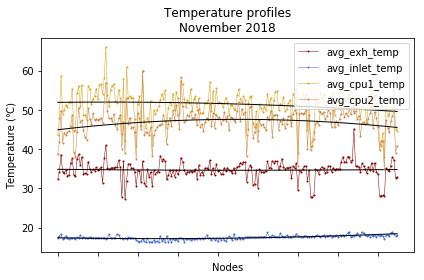

       Relative_error_l2
exh             0.068079
inlet           0.022780
cpu1            0.075101
cpu2            0.073409


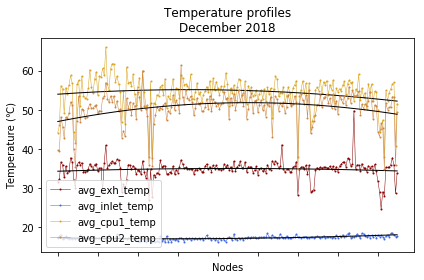

       Relative_error_l2
exh             0.080617
inlet           0.022679
cpu1            0.080364
cpu2            0.078841


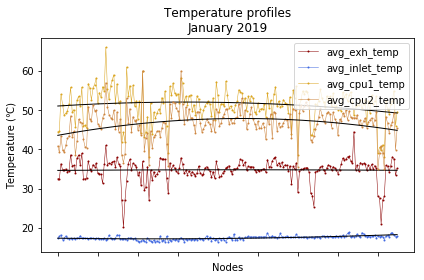

In [19]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

error_sum = pd.DataFrame(columns=['Relative_error_l2'], index=temp_types)

for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0))
#     data.sort_values(by=['avg_exh_temp'], axis=1, inplace=True)
    N = len(data.columns.values)
    x = np.arange(N)
    
    error_sum.loc[temp_types, 'Relative_error_l2'] = 0
    
    for (temp_type, temp_name, color) in zip(temp_types, temp_titles, temp_colors):

        y = data.loc['avg_'+temp_type+'_temp',:]
        z = np.poly1d(np.polyfit(x, y, 2))
        plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
        plt.plot(x, z(x), color='black', linewidth=1)
        
        error_sum.loc[temp_type, 'Relative_error_l2'] = np.linalg.norm(y-z(x))/np.linalg.norm(y)
    
    print(error_sum)
    
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Temperature profiles\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Temp_profile_by_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

5.860424028268547 0.24079636412611535


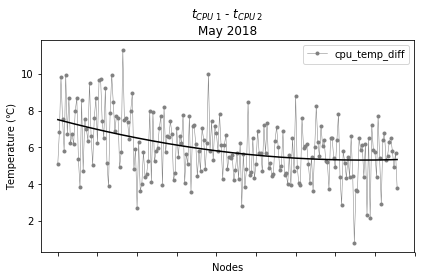

6.11963746223563 0.23003829680697802


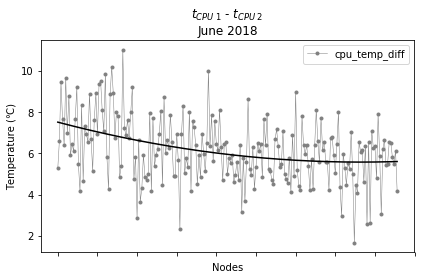

5.497762863534682 0.263146517870979


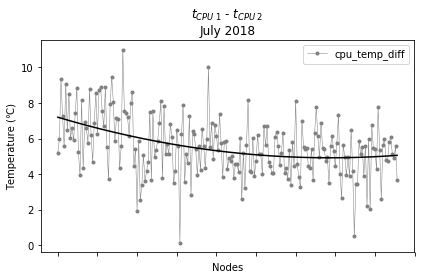

5.201027510772285 0.2781645281545378


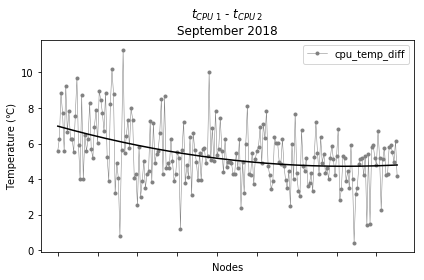

4.398443966408237 0.32225913354011665


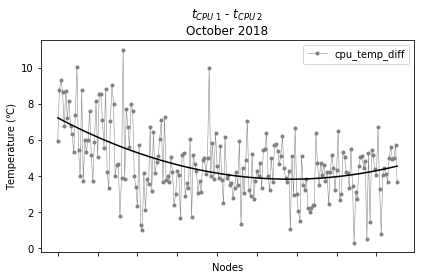

4.28438995215312 0.3324872228406247


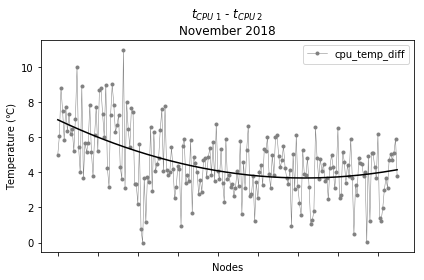

3.6875921013852135 0.3664081160971589


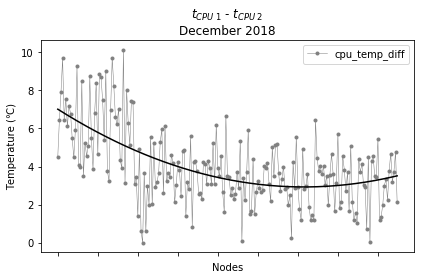

4.606168976307551 0.3308002400022433


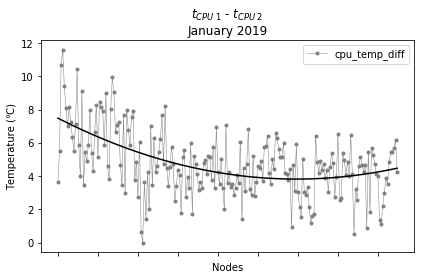

In [16]:
error_sum=0
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0))
    data.loc['cpu_temp_diff',:] = abs(data.loc['avg_cpu1_temp', :] - data.loc['avg_cpu2_temp', :])
    N = len(data.columns.values)
    x = np.arange(N)
    y = data.loc['cpu_temp_diff', :]
    z = np.poly1d(np.polyfit(x, y, 2))

    plt.plot(x, y, color='grey', marker='o', markersize=3, linewidth=0.5)#en_exit_jobs_kWh, edgecolor='black', width=1.5
    plt.plot(x, z(x), color='black')
    
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    error_sum += np.linalg.norm(y-z(x))/np.linalg.norm(y)
    print(y.median(), np.linalg.norm(y-z(x))/np.linalg.norm(y))
    month, year = extract_mm_YYYY(df_name)
    plt.title(r'$t_{CPU \; 1}$ - $t_{CPU \; 2}$' +'\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'CPU_temp_diff_by_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

In [2]:
# # 8 months - mean error
# error_sum/8

## Average temperatures for all nodes over all months

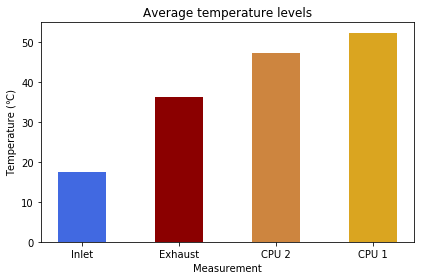

In [161]:
# Title for each bar
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']

# Colours
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

# Height of bars
data = nodes_summary_no_drop_df.filter(regex=(r'temp$'), axis=0).loc[:,'avg_all_nodes'].values

# Bars horizontal positions
x_pos = np.arange(len(data))

# Sort lists by values of the first one
data, temp_titles, temp_colors = zip(*sorted(zip(data, temp_titles, temp_colors)))

plt.bar(x_pos, data, color=temp_colors, width=0.5)
plt.xticks(x_pos, temp_titles)
plt.ylabel('Temperature (℃)')
plt.xlabel('Measurement')
plt.title('Average temperature levels')
plt.tight_layout()
plt.savefig( os.path.join( Plots_dir, 'Temp_levels_global_avg_v2.png'),dpi=900 )
plt.show()

### No outliers in temp

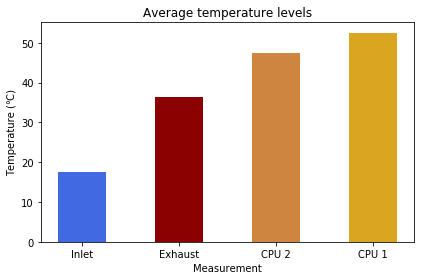

In [42]:
# Title for each bar
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']

# Colours
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

# Height of bars
data = nodes_summary_no_drop_df.filter(regex=(r'temp_no_outliers$'), axis=0).loc[:,'avg_all_nodes'].values

# Bars horizontal positions
x_pos = np.arange(len(data))

# Sort lists by values of the first one
data, temp_titles, temp_colors = zip(*sorted(zip(data, temp_titles, temp_colors)))

plt.bar(x_pos, data, color=temp_colors, width=0.5)
plt.xticks(x_pos, temp_titles)
plt.ylabel('Temperature (℃)')
plt.xlabel('Measurement')
plt.title('Average temperature levels')
plt.tight_layout()
plt.savefig( os.path.join( Plots_dir, 'Temp_levels_global_avg_no_outliers.png'),dpi=900 )
plt.show()

-----------
Monthly bars not updated for outliers exclusion

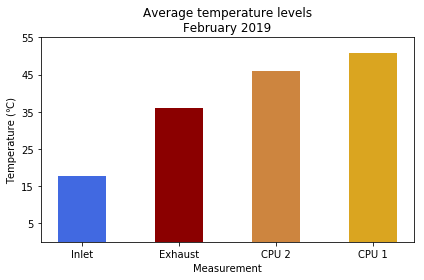

In [39]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    # Height of bars
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0)).iloc[:,-1].values

    # Bars horizontal positions
    x_pos = np.arange(len(data))

    # Sort lists by values of the first one
    # Title for each bar
    temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
    # Colours
    temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']
    data, temp_titles, temp_colors = zip(*sorted(zip(data, temp_titles, temp_colors)))

    # Plot
    plt.bar(x_pos, data, color=temp_colors, width=0.5)
    
    plt.xticks(x_pos, temp_titles)
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Measurement')
    plt.yticks(range(5,60,10))
    month, year = extract_mm_YYYY(df_name)
    plt.title('Average temperature levels\n' + month + ' ' + year)
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Temperature', 'Temp_levels_' + df_name + '.png'),dpi=900 )
    plt.show()

## Monthly avg temperatures
Not updated for the outliers exclusion

In [10]:
def weighted_mean(sample_values, sample_sizes):
    return ( (sample_values * sample_sizes).sum()/sample_sizes.sum() )

In [15]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=\
                             ['avg_'+temp_type+'_temp_no_outliers' for temp_type in temp_types])
entries_col = nodes_no_drop_df_dict[df_name].filter(regex=('_entries_in_month$'), axis=0).index.values
entries_in_month = pd.DataFrame(data=0, index=nodes_df_names, columns=entries_col)
for df_name in nodes_df_names:
    temp_stats_month_df = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].\
                                                           filter(regex=('_temp_no_outliers$'), axis=0))
    entries_in_month.loc[df_name, entries_col] = nodes_no_drop_df_dict[df_name].loc[entries_col, :].sum()
    for col_name in temp_by_month.columns.values[:]:
        temp_by_month.loc[df_name, col_name] = weighted_mean(temp_stats_month_df.loc[col_name, :], \
                                                             nodes_no_drop_df_dict[df_name].loc['entries_in_month', :])
temp_by_month.loc[:,'delta_t'] = temp_by_month.avg_exh_temp_no_outliers - temp_by_month.avg_inlet_temp_no_outliers
temp_by_month.loc[:,'cpu1_cooled_delta_t'] = temp_by_month.avg_cpu1_temp_no_outliers - temp_by_month.avg_exh_temp_no_outliers
temp_by_month.loc[:,'cpu2_cooled_delta_t'] = temp_by_month.avg_cpu2_temp_no_outliers - temp_by_month.avg_exh_temp_no_outliers
temp_by_month

,avg_exh_temp_no_outliers,avg_inlet_temp_no_outliers,avg_cpu1_temp_no_outliers,avg_cpu2_temp_no_outliers,delta_t,cpu1_cooled_delta_t,cpu2_cooled_delta_t
May2018_idle,38.946137,17.724671,54.276350,48.311002,21.221466,15.330214,9.364865
June2018_idle,38.452575,17.829111,52.533097,46.375446,20.623465,14.080521,7.922871
July2018_idle,38.288785,17.913317,53.970274,48.415968,20.375468,15.681488,10.127183
September2018,36.696826,17.756201,51.598057,46.255747,18.940626,14.901230,9.558921
October2018,35.395017,17.795646,51.985439,47.339679,17.599371,16.590422,11.944662
November2018,34.300440,17.288426,50.758975,46.294321,17.012014,16.458535,11.993881
December2018,34.316502,17.065471,53.676964,49.809995,17.251031,19.360462,15.493493
January2019,34.256024,17.217679,50.625272,45.961425,17.038345,16.369248,11.705401
February2019,35.220915,17.064414,50.521188,44.858965,18.156502,15.300273,9.638050


In [78]:
print('Mean:\t\t', round(temp_by_month.cpu1_cooled_delta_t.mean(), 2), round(temp_by_month.cpu2_cooled_delta_t.mean(), 2))
# print('Unbiased mean:\t', \
#       round(weighted_mean(temp_by_month.cpu1_cooled_delta_t, entries_in_month.entries_in_month), 2),\
#       round(weighted_mean(temp_by_month.cpu2_cooled_delta_t, entries_in_month.entries_in_month), 2))

Mean:		 16.01 10.86


-------------
No temp outliers exclusion

In [47]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_by_month    = pd.DataFrame(data=0, index=nodes_df_names, columns=['avg_' + i + '_temp' for i in temp_types])
entries_in_month = pd.DataFrame(data=0, index=nodes_df_names, columns=[i + '_temp_entries_in_month' for i in temp_types])
for df_name in nodes_df_names:
    temp_stats_month_df = nodes_no_drop_df_dict[df_name].loc[temp_by_month.columns.values, :]
    
    entries_in_month_df = nodes_no_drop_df_dict[df_name].loc[entries_in_month.columns.values, :]
    
    entries_in_month.loc[df_name,:] = entries_in_month_df.sum( axis=1 )
    
    for col_name_temp, col_name_entries in zip( temp_stats_month_df.index.values, entries_in_month_df.index.values ):
        temp_by_month.loc[df_name, col_name_temp] = weighted_mean( temp_stats_month_df.loc[col_name_temp, :], \
                                                               entries_in_month_df.loc[col_name_entries, :])
        
        
temp_by_month.loc[:,'delta_t'] = temp_by_month.avg_exh_temp - temp_by_month.avg_inlet_temp
temp_by_month.loc[:,'cpu1_cooled_delta_t'] = temp_by_month.avg_cpu1_temp - temp_by_month.avg_exh_temp
temp_by_month.loc[:,'cpu2_cooled_delta_t'] = temp_by_month.avg_cpu2_temp - temp_by_month.avg_exh_temp
temp_by_month

,avg_exh_temp,avg_inlet_temp,avg_cpu1_temp,avg_cpu2_temp,delta_t,cpu1_cooled_delta_t,cpu2_cooled_delta_t
May2018_idle,38.968105,17.724682,54.292690,48.322121,21.243424,15.324585,9.354015
June2018_idle,38.456587,17.829080,52.548595,46.396539,20.627507,14.092008,7.939952
July2018_idle,38.304042,17.913148,54.012454,48.471822,20.390894,15.708412,10.167780
September2018,36.889713,17.837584,51.897211,46.527379,19.052128,15.007498,9.637667
October2018,35.562600,17.877395,52.240913,47.568192,17.685205,16.678313,12.005592
November2018,34.687214,17.482118,51.349629,46.829028,17.205096,16.662415,12.141814
December2018,34.800649,17.305732,54.442140,50.512625,17.494917,19.641491,15.711976
January2019,34.745787,17.460612,51.375307,46.643497,17.285175,16.629521,11.897711
February2019,35.717353,17.302695,51.247271,45.498943,18.414658,15.529918,9.781590


In [49]:
print('Mean of cooled delta_t:\t\t\t', round(temp_by_month.cpu1_cooled_delta_t.mean(), 2), round(temp_by_month.cpu2_cooled_delta_t.mean(), 2))
# print('Unbiased mean of cooled delta_t:\t', \
#       round(weighted_mean(temp_by_month.cpu1_cooled_delta_t, entries_in_month.entries_in_month), 2),\
#       round(weighted_mean(temp_by_month.cpu2_cooled_delta_t, entries_in_month.entries_in_month), 2))

Mean of cooled delta_t:			 16.14 10.96


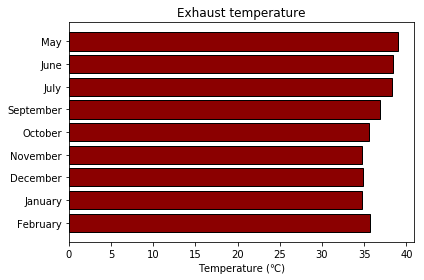

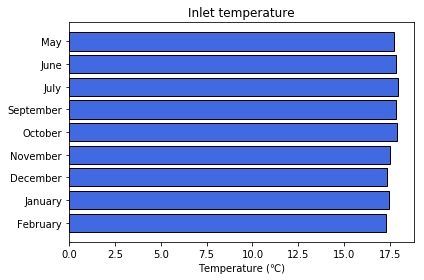

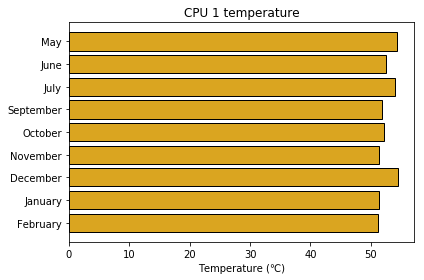

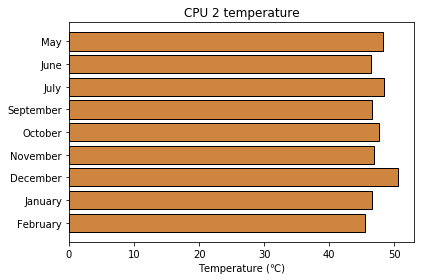

In [51]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

N = len(temp_by_month.index)
ind = np.arange(N)

for (col_name, temp_title, color) in zip(temp_by_month.columns.values, temp_titles, temp_colors):

    fig, ax = plt.subplots()

    p1 = plt.barh(ind, temp_by_month.loc[:,col_name], color=color, edgecolor='black')#saddlebrown

    plt.title( temp_title + ' temperature')
    plt.xlabel('Temperature (℃)')
    plt.yticks(ind, ('May', 'June', 'July',\
                    'September','October', 'November', 'December',\
                    'January', 'February'))
    ax.invert_yaxis()
    plt.tight_layout()
    fig.savefig(os.path.join(Plots_dir, temp_title+'_temp_by_month.png'), dpi=900)
    plt.show()

----------
Updated for February inclusion and then outliers exclusion

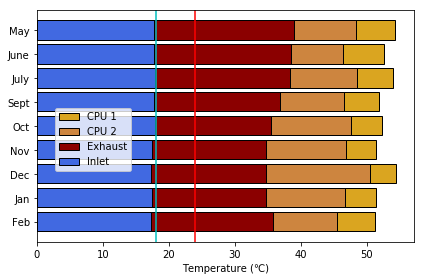

In [76]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

fig, ax = plt.subplots()

N = len(temp_by_month.index)
ind = np.arange(N)

p4 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu1_temp'], color=temp_colors[2], edgecolor='black')#saddlebrown
p3 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu2_temp'], color=temp_colors[3], edgecolor='black')#saddlebrown
p2 = plt.barh(ind, temp_by_month.loc[:,'avg_exh_temp'], color=temp_colors[0], edgecolor='black')#saddlebrown
p1 = plt.barh(ind, temp_by_month.loc[:,'avg_inlet_temp'], color=temp_colors[1], edgecolor='black')#saddlebrown

xcoords = [18., 24.]
colors = ['c', 'r']
labels = ['Cold aisle setpoint', 'Hot aisle setpoint']
for xc,c,line_label in zip(xcoords,colors, labels):
    plt.axvline(x=xc, label=line_label, c=c)

# Decoration
# plt.title( 'Average temperature observed every month')
plt.xlabel('Temperature (℃)')
plt.yticks(ind, ('May', 'June', 'July',\
                'Sept','Oct', 'Nov', 'Dec',\
                'Jan', 'Feb'))
ax.invert_yaxis()

lgd = plt.legend((p4[0], p3[0], p2[0], p1[0]), ('CPU 1', 'CPU 2', 'Exhaust', 'Inlet', ),\
             loc='upper center', bbox_to_anchor=(0.15, 0.6))

# Y-labels not cut off
plt.tight_layout()

fig.savefig(os.path.join(Plots_dir, 'Temp_levels_by_month.png'), dpi=900)
plt.show()

In [69]:
ind.min()

0

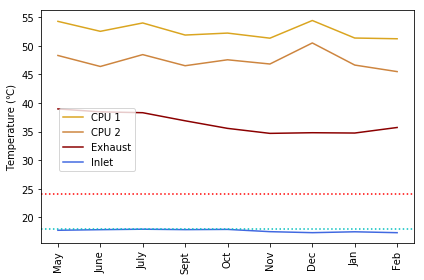

In [77]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

fig, ax = plt.subplots()

N = len(temp_by_month.index)
ind = np.arange(N)

p4 = plt.plot(ind, temp_by_month.loc[:,'avg_cpu1_temp'], color=temp_colors[2])#saddlebrown , edgecolor='black'
p3 = plt.plot(ind, temp_by_month.loc[:,'avg_cpu2_temp'], color=temp_colors[3])#saddlebrown , edgecolor='black'
p2 = plt.plot(ind, temp_by_month.loc[:,'avg_exh_temp'], color=temp_colors[0])#saddlebrown , edgecolor='black'
p1 = plt.plot(ind, temp_by_month.loc[:,'avg_inlet_temp'], color=temp_colors[1])#saddlebrown , edgecolor='black'

xcoords = [18., 24.]
colors = ['c', 'r']
labels = ['Cold aisle setpoint', 'Hot aisle setpoint']
for xc,c,line_label in zip(xcoords,colors, labels):
    plt.axhline(y=xc, xmin=0, xmax=ind.max(), label=line_label, c=c, linestyle=':')

# Decoration
# plt.title( 'Average temperature observed every month')
plt.ylabel('Temperature (℃)')
plt.xticks(ind, ('May', 'June', 'July',\
                'Sept','Oct', 'Nov', 'Dec',\
                'Jan', 'Feb'), rotation=90)
# ax.invert_yaxis()

lgd = plt.legend((p4[0], p3[0], p2[0], p1[0]), ('CPU 1', 'CPU 2', 'Exhaust', 'Inlet', ),\
             loc='upper center', bbox_to_anchor=(0.15, 0.6))

# Y-labels not cut off
plt.tight_layout()

fig.savefig(os.path.join(Plots_dir, 'Temp_levels_by_month_lines.png'), dpi=900)
plt.show()

In [75]:
# temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
# temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

# fig, ax = plt.subplots()

# N = len(temp_by_month.index)
# ind = np.arange(N)

# p4 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu1_temp_no_outliers'], color=temp_colors[2], edgecolor='black')#saddlebrown
# p3 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu2_temp_no_outliers'], color=temp_colors[3], edgecolor='black')#saddlebrown
# p2 = plt.barh(ind, temp_by_month.loc[:,'avg_exh_temp_no_outliers'], color=temp_colors[0], edgecolor='black')#saddlebrown
# p1 = plt.barh(ind, temp_by_month.loc[:,'avg_inlet_temp_no_outliers'], color=temp_colors[1], edgecolor='black')#saddlebrown

# xcoords = [18., 24.]
# colors = ['c', 'r']
# labels = ['Cold aisle setpoint', 'Hot aisle setpoint']
# for xc,c,line_label in zip(xcoords,colors, labels):
#     plt.axvline(x=xc, label=line_label, c=c)

# # Decoration
# plt.title( 'Average temperature observed every month')
# plt.xlabel('Temperature (℃)')
# plt.yticks(ind, ('May', 'June', 'July',\
#                 'September','October', 'November', 'December',\
#                 'January', 'February'))
# ax.invert_yaxis()

# lgd = plt.legend((p4[0], p3[0], p2[0], p1[0]), ('CPU 1', 'CPU 2', 'Exhaust', 'Inlet', ),\
#              loc='upper center', bbox_to_anchor=(0.15, 0.6))

# # Y-labels not cut off
# plt.tight_layout()

# fig.savefig(os.path.join(Plots_dir, 'Temp_levels_by_month_no_outliers.png'), dpi=900)
# plt.show()

## $\Delta$Temperature = exhaust - inlet
Not updated for Feb or outliers

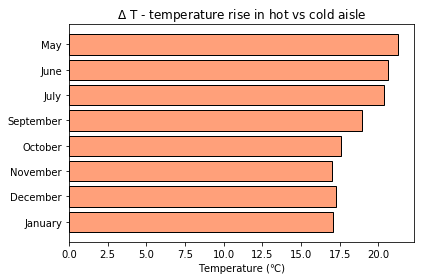

In [95]:
fig, ax = plt.subplots()

N = temp_by_month.shape[0]
ind = np.arange(N)    
width = 0.35

p1 = plt.barh(ind, temp_by_month.delta_t, color='lightsalmon', edgecolor='black')#saddlebrown

plt.title(r'$\Delta$ T - temperature rise in hot vs cold aisle')
plt.xlabel('Temperature (℃)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'Delta_t_by_month.png'),dpi=900)
plt.show()

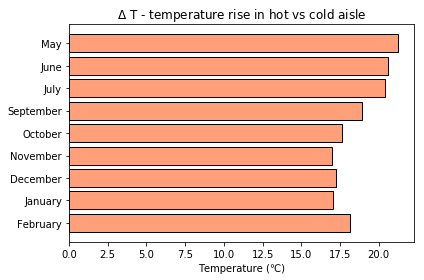

In [16]:
fig, ax = plt.subplots()

N = temp_by_month.shape[0]
ind = np.arange(N)    
width = 0.35

p1 = plt.barh(ind, temp_by_month.delta_t, color='lightsalmon', edgecolor='black')#saddlebrown

plt.title(r'$\Delta$ T - temperature rise in hot vs cold aisle')
plt.xlabel('Temperature (℃)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January', 'February'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'Delta_t_by_month_no_outliers.png'),dpi=900)
plt.show()

## $\Delta$ T ranges by nodes for every month
Not updated for Feb or outliers

0.0035682426405010403 26.139699381078696 21.369353410097435


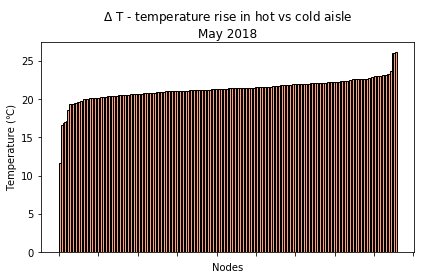

0.006628502561014216 26.0 20.72689201316183


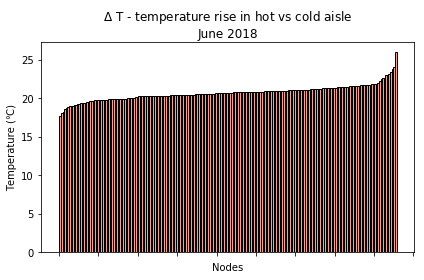

0.011671686746989707 26.259507829977636 20.41163310961969


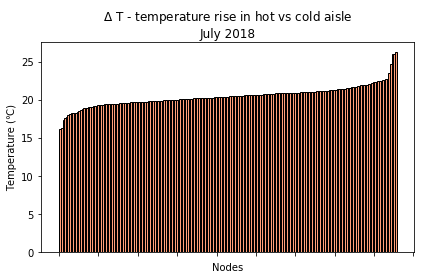

2.921445144182961 26.979781239642023 19.098442161087174


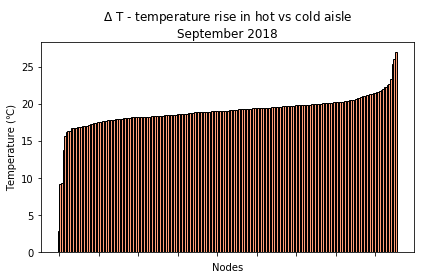

6.727006444053899 27.724077328646747 17.686530014641285


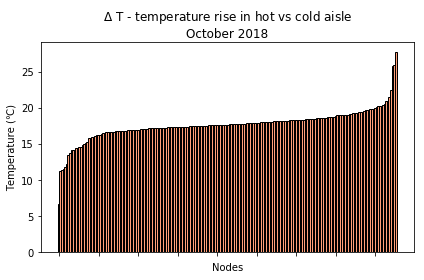

9.956638755980862 27.381393957523176 17.360047846889948


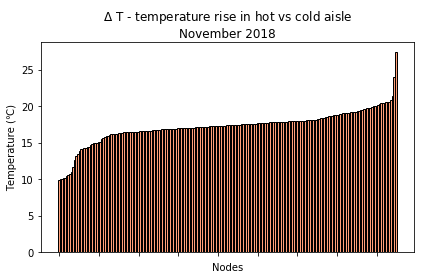

6.7612028301886795 32.331859711170054 17.746462264150942


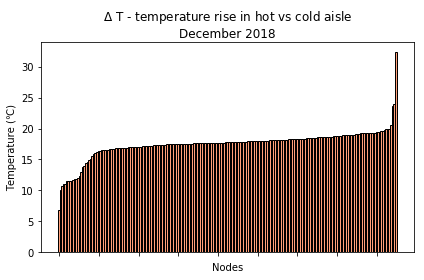

3.005361930294903 26.77469825659366 17.60661600357622


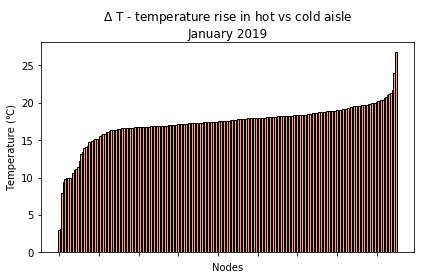

In [35]:
for df_name in nodes_df_names:
    temp_stats_month_df = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].filter(regex=('temp$'), axis=0))
    
    data = (temp_stats_month_df.loc['avg_exh_temp', :] - temp_stats_month_df.loc['avg_inlet_temp', :]).sort_values()
    print(data.min(), data.max(), data.median())
    fig, ax = plt.subplots()
    N = temp_stats_month_df.shape[1]
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='lightsalmon', edgecolor='black', width=1.5)
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    month, year = extract_mm_YYYY(df_name)
    plt.title(r'$\Delta$ T - temperature rise in hot vs cold aisle' +'\n' + month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Delta_t_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

---------------
## Idle mode investigation

### Energy consumed in idle state per month

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


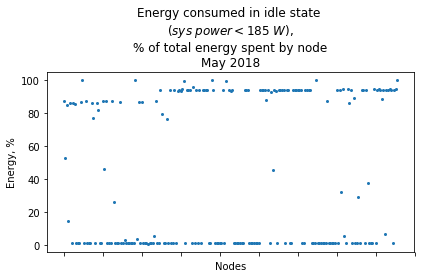

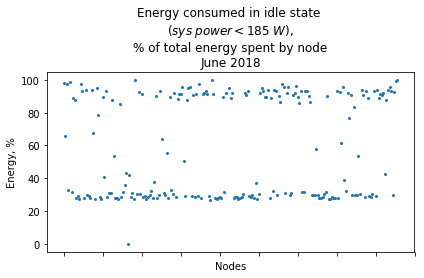

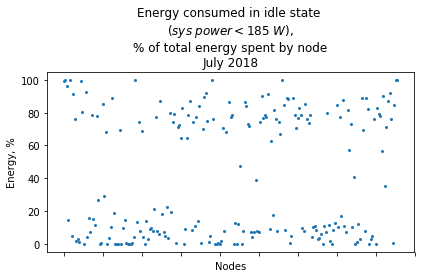

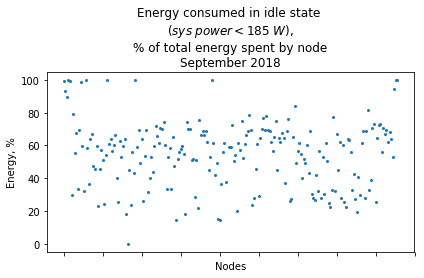

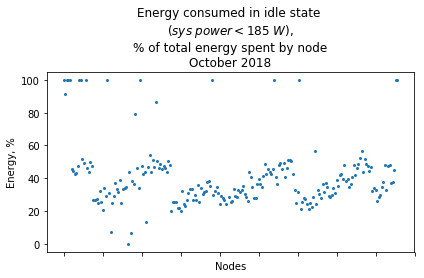

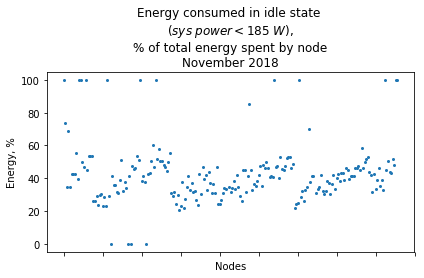

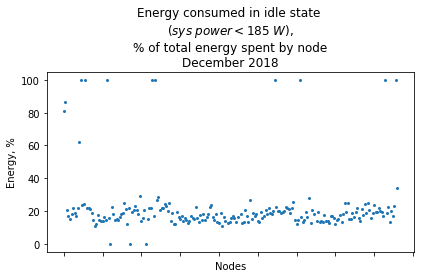

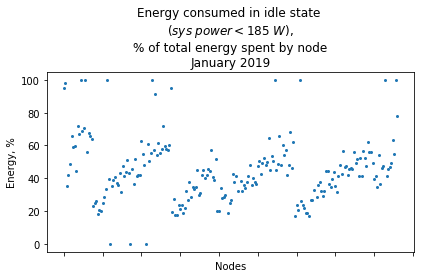

In [47]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = month_df.loc['idle_en_integral', :] / month_df.loc['sys_energy', :] * 100.
    N = len(data)
    x = np.arange(N)
        

    y = data
    z = np.poly1d(np.polyfit(x, y, 10))
    plt.scatter(x, y, marker='o', s=4)
#     plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
#     plt.plot(x, z(x), color='black', linewidth=1)
        
    plt.ylabel('Energy, %')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Energy consumed in idle state \n'+r'$(sys \; power < 185 \; W)$,'+'\n% of total energy spent by node\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Portion_idle_leq184_energy_of_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

### Time spent in idle mode per month

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


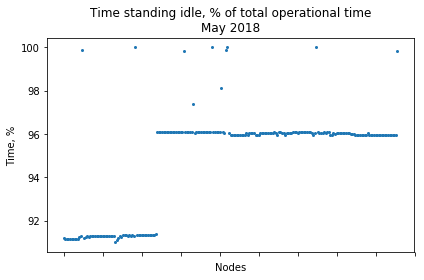

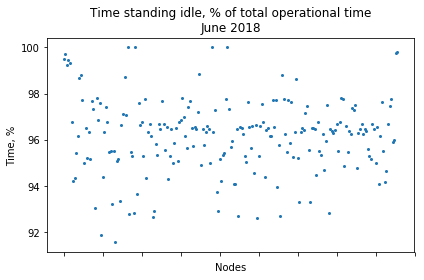

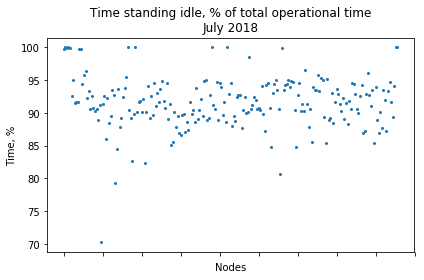

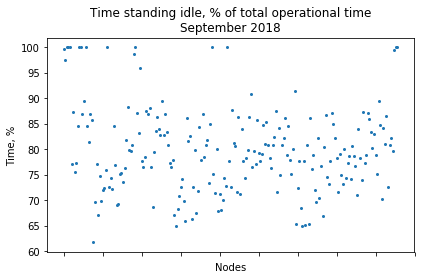

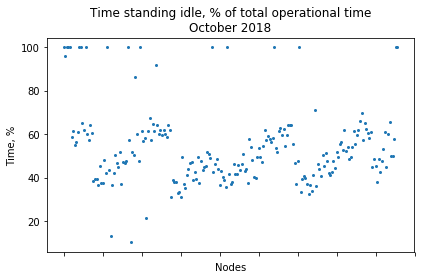

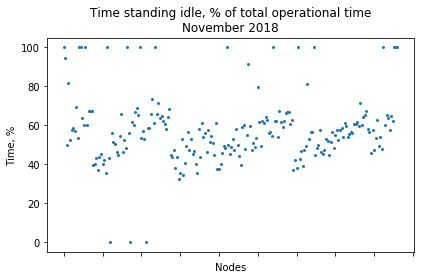

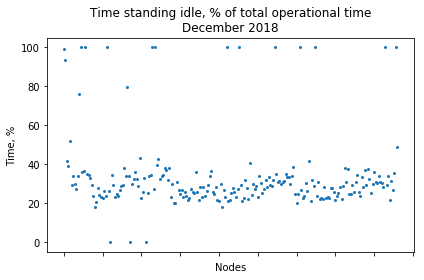

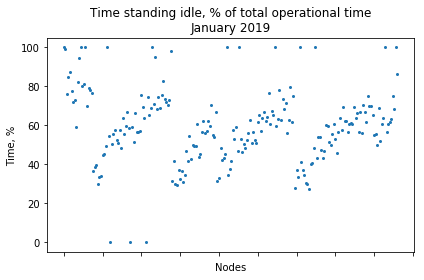

In [33]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = month_df.loc['idle_time_sec', :] / month_df.loc['working_time_sec', :] * 100.
    N = len(data)
    x = np.arange(N)
        

    y = data
    z = np.poly1d(np.polyfit(x, y, 10))
    plt.scatter(x, y, marker='o', s=4)
#     plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
#     plt.plot(x, z(x), color='black', linewidth=1)
        
    plt.ylabel('Time, %')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Time standing idle, \n% of total operational time\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
#     fig.savefig( os.path.join( Plots_dir, 'Portion_idle_time_of_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

In [83]:
# Based on no_drop dataset
energy_by_month = pd.read_csv(os.path.join( Output_dir, 'energy_summary_by_month.csv'), sep=";", index_col=0)

# energy_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['total_dcenergy_MWh', 'total_sys_energy_no_drop_MWh'])

# for df_name in nodes_df_names:
#     energy_by_month.loc[df_name, 'total_dcenergy_MWh'] = nodes_df_dict[df_name].loc['total_dcenergy', :].sum()
#     energy_by_month.loc[df_name, 'total_sys_energy_no_drop_MWh'] = nodes_no_drop_df_dict[df_name].loc['sys_energy', :].sum()
#     energy_by_month.loc[df_name, 'idle_energy_no_drop_MWh'] = nodes_no_drop_df_dict[df_name].loc['idle_en_integral', :].sum()

# energy_by_month = energy_by_month/1000.

# energy_by_month.loc[:, 'idle_energy_percent_MWh'] = energy_by_month.idle_energy_no_drop_MWh / \
#                                                                 energy_by_month.total_sys_energy_no_drop_MWh * 100.

energy_by_month

,total_dcenergy_MWh,total_sys_energy_MWh,idle_energy_MWh,idle_energy_percent_MWh
May2018_idle,14.693,15.761,6.841,43.404
June2018_idle,24.173,27.456,15.864,57.780
July2018_idle,21.624,24.611,9.690,39.371
September2018,22.969,25.461,13.657,53.638
October2018,27.048,32.490,12.582,38.726
November2018,26.540,31.381,12.838,40.908
December2018,33.023,37.567,7.617,20.275
January2019,19.393,21.489,9.163,42.637
February2019,21.274,23.778,14.050,59.088


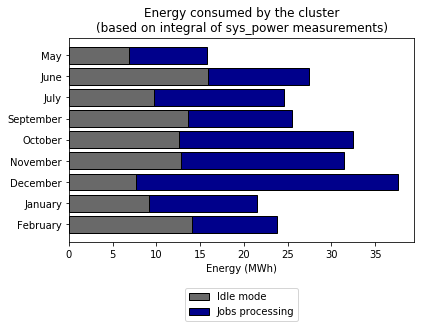

In [84]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, energy_by_month.idle_energy_MWh, color='dimgray', edgecolor='black')#saddlebrown
p2 = plt.barh(ind, energy_by_month.total_sys_energy_MWh - energy_by_month.idle_energy_MWh, \
              color='darkblue', edgecolor='black', left=energy_by_month.idle_energy_MWh )#saddlebrown

plt.title('Energy consumed by the cluster\n(based on integral of sys_power measurements)')
plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January', 'February'))
ax.invert_yaxis()

lgd = plt.legend((p1[0], p2[0]), ('Idle mode', 'Jobs processing'),\
             loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.tight_layout()

fig.savefig(os.path.join(Plots_dir, 'idle_energy_cons_by_month_sys_power_int.png'),\
            bbox_extra_artists=(lgd,), bbox_inches='tight',\
            dpi=300)
plt.show()

## Distribution of sudden drops/highs of temperature and power

1.0 	 1
5.0 	 5
18.0 	 18
17.0 	 17
179.0 	 179
27.0 	 27
20.0 	 20
68.0 	 68
469.0 	 469
57.0 	 57
19.0 	 19
32.0 	 32
171.0 	 171
17.0 	 17
23.0 	 23
2.0 	 2
2.0 	 2
1.0 	 1


c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


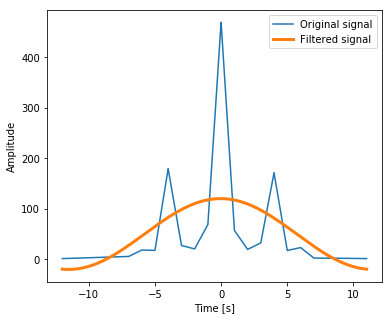

In [69]:
node_df = data_prep_df[nodes_df_names[0]].copy()
nodename = nodes_no_drop_df_dict[df_name].columns.values[0]
one_node_df = node_df[node_df.nodename == nodename].copy()


# Read temperature differences
temp_difference = (one_node_df['exh_temp'][1:].values -\
    one_node_df['exh_temp'][:-1].values)
counter = collections.Counter(temp_difference)
keys, values = zip(*sorted(zip([*counter.keys()],[*counter.values()])))

sig = interpolate.interp1d(keys, values)
for i in range(len(keys)):
    print(sig(keys[i]), '\t', values[i])
time_step = 0.0001
time_vec = np.arange(min(keys), max(keys), time_step)
# The FFT of the signal
sig_fft = fftpack.fft(sig(time_vec))

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(len(time_vec), d=time_step)

# # Plot the FFT power
# plt.figure(figsize=(6, 5))
# plt.plot(sample_freq, power)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('plower')
# plt.show()

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig(time_vec), label='Original signal')
# plt.bar([*counter.keys()], [*counter.values()], label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')
plt.show()

initialized
0.0


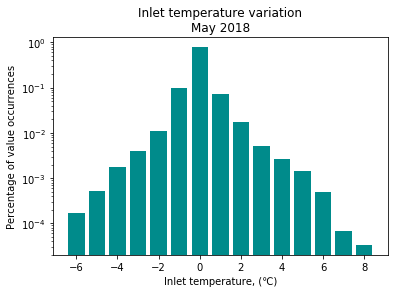

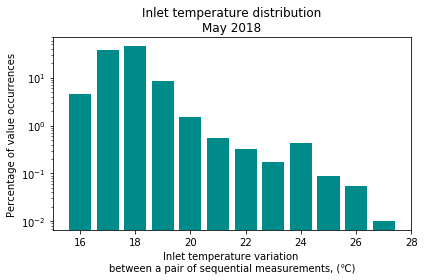

initialized
0.0


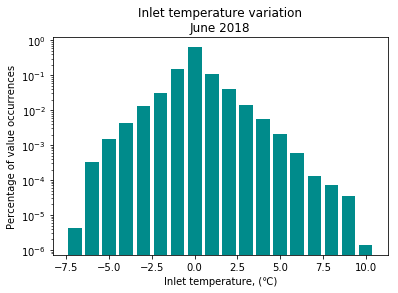

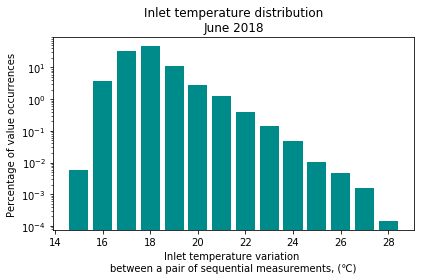

initialized
0.0


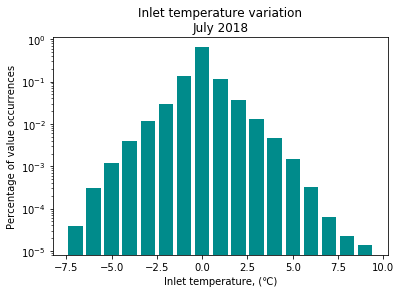

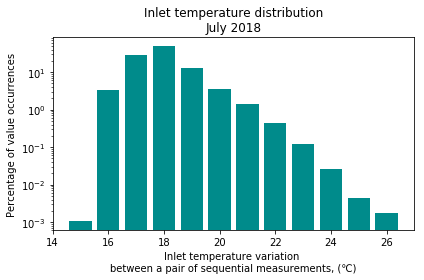

initialized
0.0


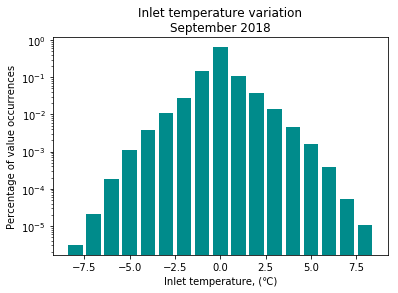

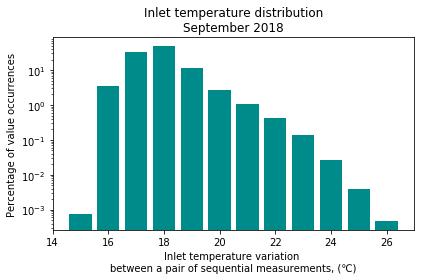

initialized
0.0


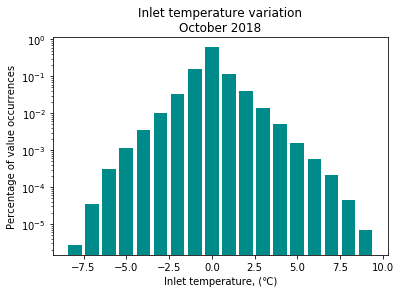

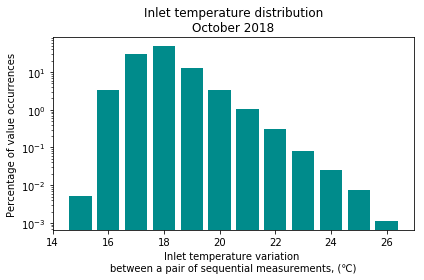

initialized
0.0


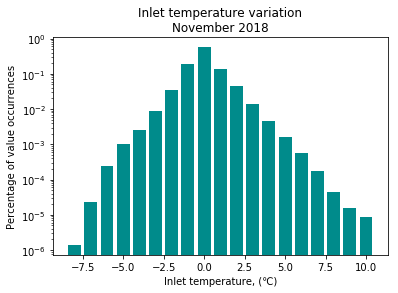

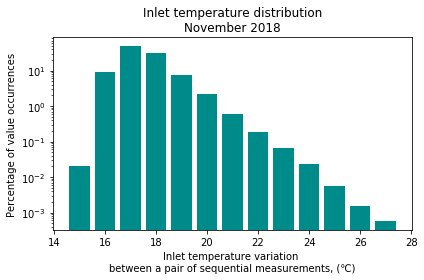

initialized
0.0


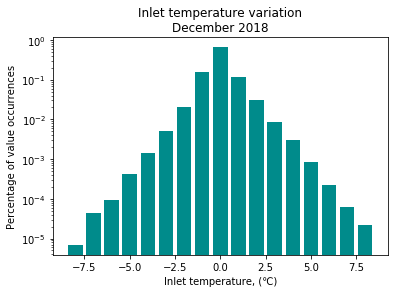

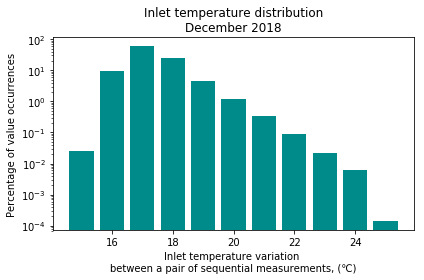

initialized
1.0


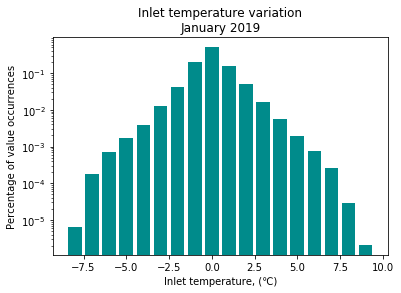

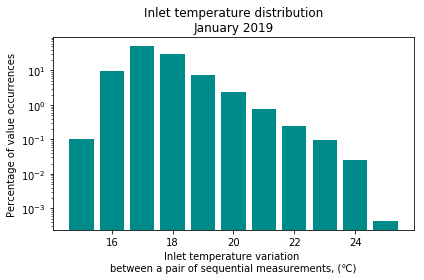

initialized
0.0


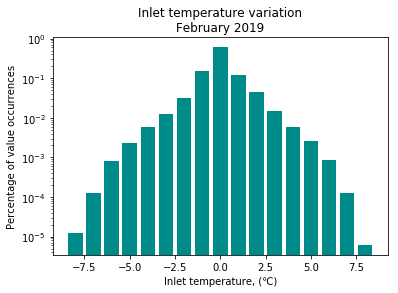

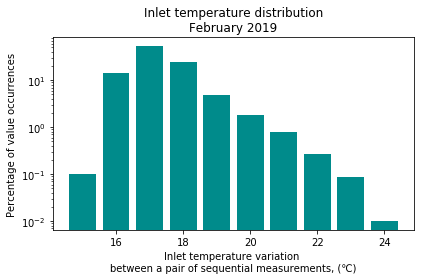

initialized
0.0


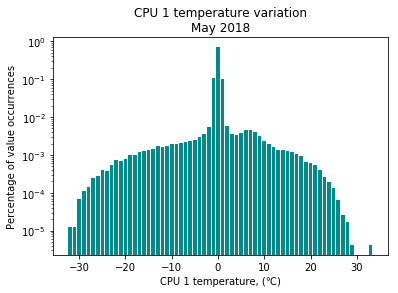

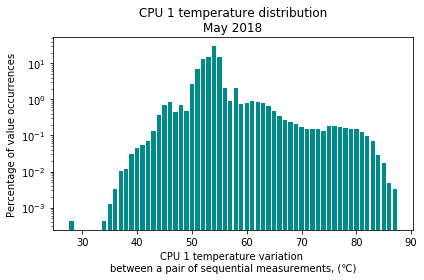

initialized
0.0


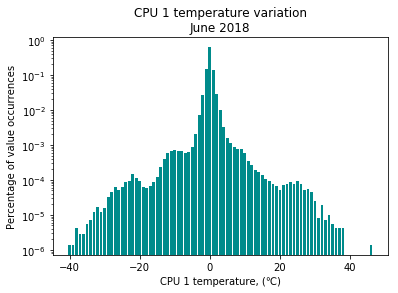

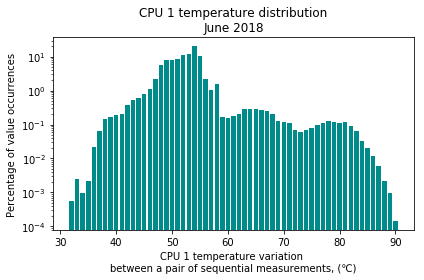

initialized
0.0


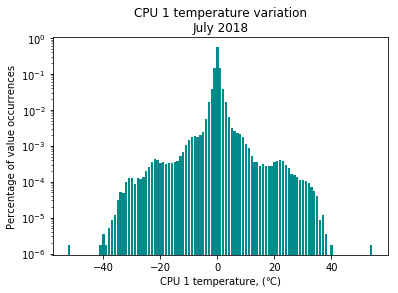

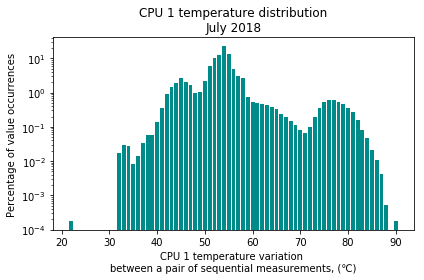

initialized
0.0


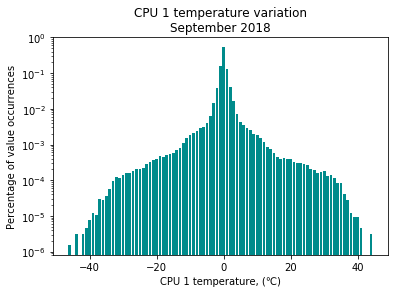

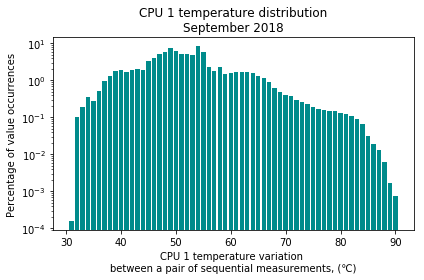

initialized
2.0


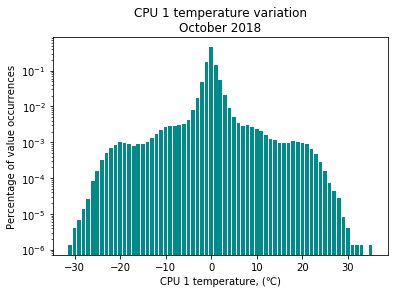

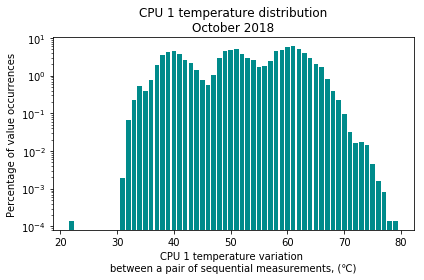

initialized
2.0


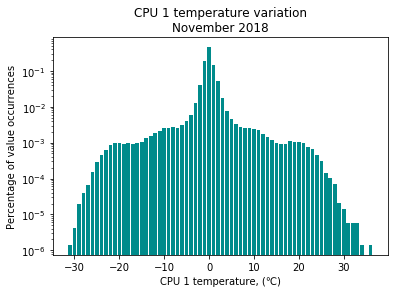

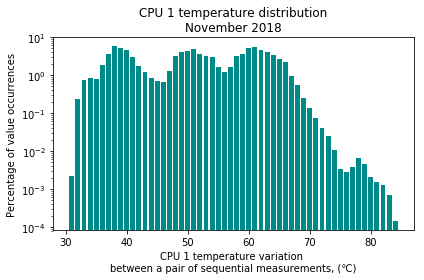

initialized
1.0


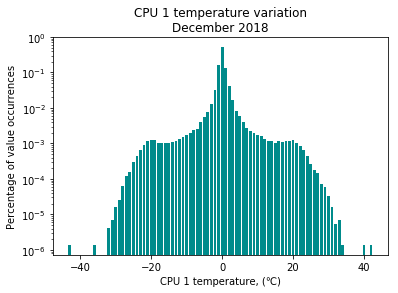

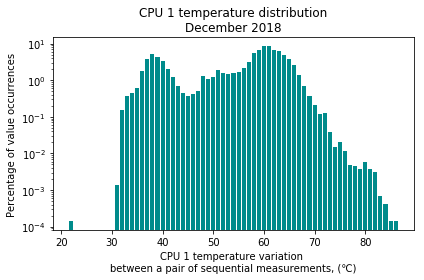

initialized
2.0


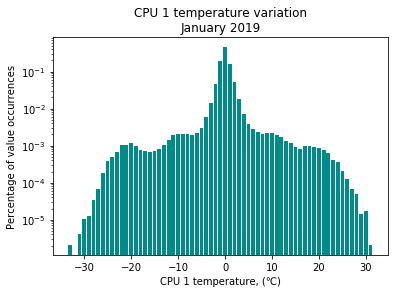

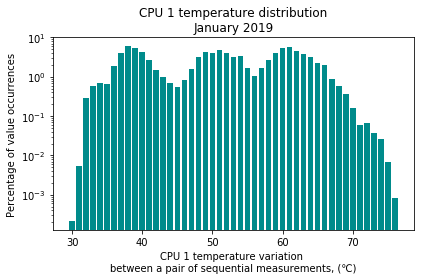

initialized
0.0


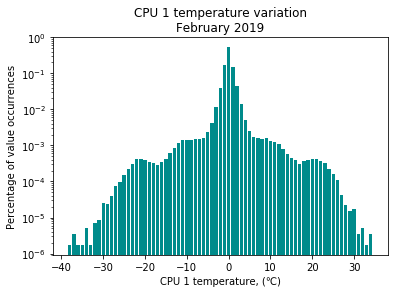

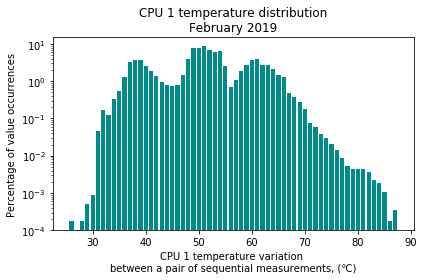

initialized
0.0


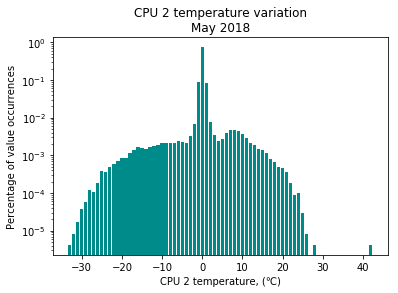

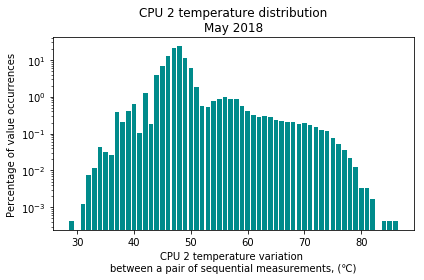

initialized
0.0


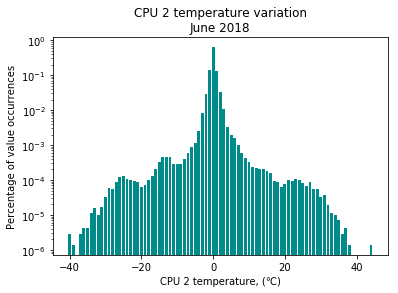

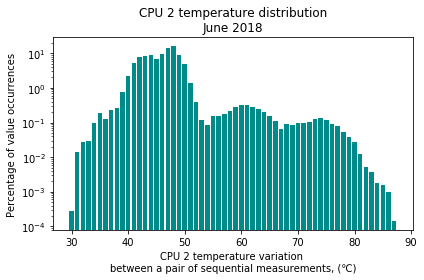

initialized
0.0


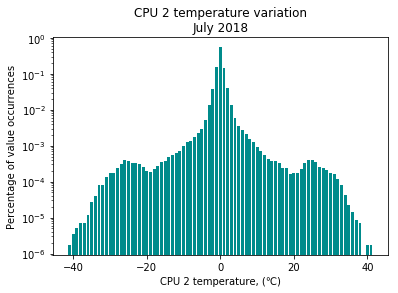

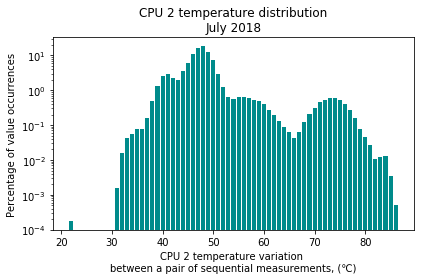

initialized
0.0


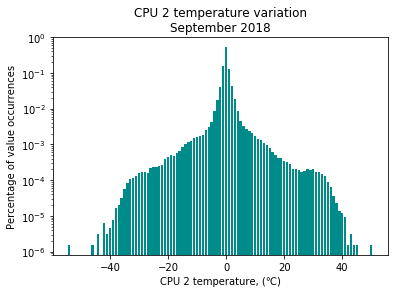

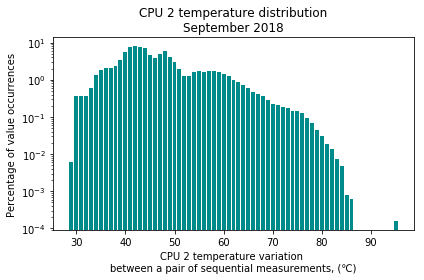

initialized
2.0


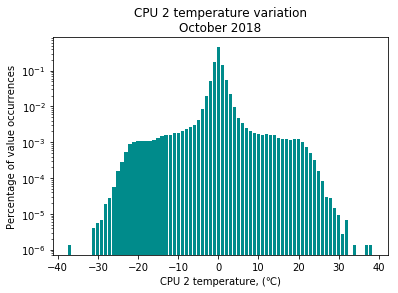

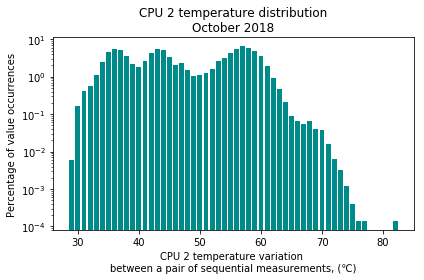

initialized
2.0


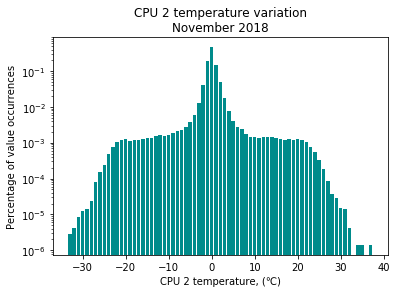

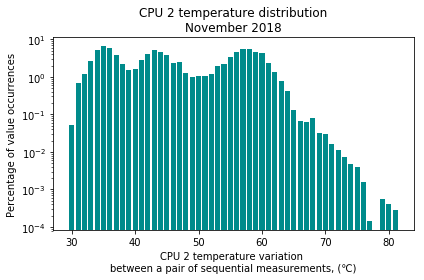

initialized
0.0


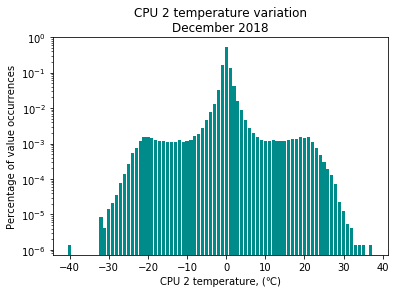

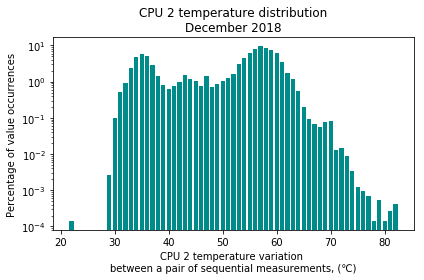

initialized
2.0


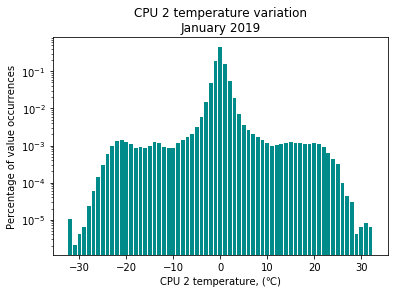

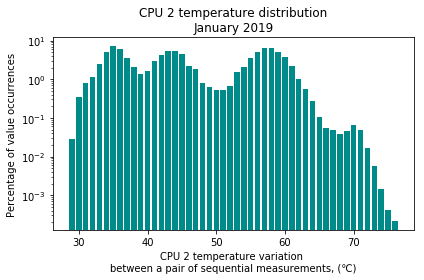

initialized
1.0


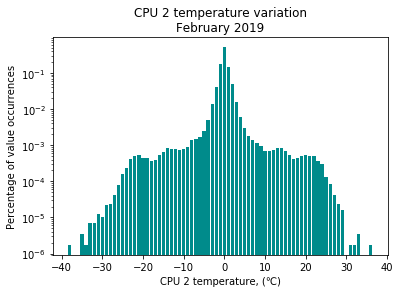

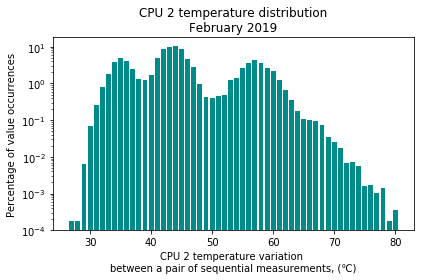

In [14]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']

for temp_type, temp_title in zip(temp_types[1:], temp_titles[1:]):
    for df_name in nodes_df_names:
        node_df = data_prep_df[df_name].copy()

        for node in node_names:
            one_node_df = node_df[node_df.nodename == node].copy()
            
            one_node_temp_df = one_node_df.copy()
            one_node_temp_df = one_node_temp_df[~ one_node_temp_df.\
                                                loc[:, temp_type+'_temp'+ _no_outliers].\
                                                isin([0, np.nan, np.inf, -np.inf])]
            
            # Read temperature differences
            temp_difference = ( one_node_temp_df[temp_type+'_temp'+ _no_outliers][1:].values - \
                                one_node_temp_df[temp_type+'_temp'+ _no_outliers][:-1].values )
            
            # Check that time difference between consecutive measurements < 30 mins
            time_difference = ( one_node_temp_df['unix_timestamp'][1:].values - \
                                one_node_temp_df['unix_timestamp'][:-1].values )
            # Period between measurements
            freq_meas_ix = np.where( time_difference < 30*60 )[0]
            
            temp_difference_init = temp_difference.copy()
            temp_difference = temp_difference[freq_meas_ix]
            
            counter_one_node = collections.Counter(temp_difference)
            if (node == 'cresco6x001'):
#                 print('initialized')
                counter = counter_one_node.copy()
                temp_diff_month = temp_difference.tolist()
            else:
                counter = counter + counter_one_node
                temp_diff_month = temp_diff_month + temp_difference.tolist()


        fig, ax = plt.subplots()
        plt.title(temp_title+' temperature variation\n' +\
                  str(extract_mm_YYYY(df_name)[0]) + ' ' +\
                  str(extract_mm_YYYY(df_name)[1]))
        keys, values = zip(*sorted(zip([*counter.keys()],[*counter.values()])))
        
        values = values / np.float64(sum(values))
        mean = np.average(a=keys, weights=values)
        variance = np.var(temp_diff_month, ddof=1)

        # Exhaust
#         ax.text((min(keys) + max(keys))/2.3, min(values)/10, \
#                 'mean {:f}, stdvar {:2.2f}'.format(round(mean,5), round(variance, 2)), \
#                 bbox={'alpha':0.5, 'pad':10})
        # Inlet
#         ax.text(-2,  min(values)/10, 'mean {:f}, stdvar {:2.2f}'.format(round(mean,5), round(variance, 2)), 
#             bbox={'alpha':0.5, 'pad':10})#style='italic',
        plt.bar(keys, values, color='darkcyan')
        plt.yscale('log')
        plt.ylabel('Percentage of value occurrences')
        plt.xlabel(temp_title+' temperature, (℃)')
        
#         gamma = stats.iqr(temp_diff_month, nan_policy='omit')
#         print(gamma)
#         gamma = np.float64(.5)
        
#         plt.plot(keys, np.exp( - (keys - mean)**2 / (2 * variance**2) )/(np.sqrt(2. * np.pi) * variance), color='yellow')
#         plt.plot(keys, 1. / ( np.pi * gamma * (1 + (keys / gamma) ** 2 ) ), color='k')
    
        plt.show()
        fig.savefig( os.path.join( Plots_dir, temp_title+'_temp_variation_'+df_name+'.png'),dpi=300)


        fig, ax = plt.subplots()
        plt.title(temp_title+' temperature distribution\n' +\
                  str(extract_mm_YYYY(df_name)[0]) + ' ' +\
                  str(extract_mm_YYYY(df_name)[1]))
        
        counter_temp = collections.Counter(node_df.loc[:,temp_type+'_temp'+ _no_outliers].dropna()) 
        keys, values = zip(*sorted(zip([*counter_temp.keys()],[*counter_temp.values()])))
        values = values / np.float64(sum(values)) * 100.
        
        mean = np.average(a=keys, weights=values)
        variance = np.var(temp_diff_month, ddof=1)
#         # Exhaust
#         ax.text((min(keys) + max(keys))/2.3, min(values)/10, 'mean {:f}, stdvar {:2.2f}'.format(round(mean,5), round(variance, 2)), 
#             bbox={'alpha':0.5, 'pad':10})
        # Inlet
#         ax.text((min(keys) + max(keys))/2.3, min(values)/10, 'mean {:f}, stdvar {:2.2f}'.format(round(mean,5), round(variance, 2)), 
#             bbox={'alpha':0.5, 'pad':10})
        
        plt.bar(keys, values, color='darkcyan')
        plt.yscale('log')
        plt.ylabel('Percentage of value occurrences')
        plt.xlabel(temp_title+' temperature variation \nbetween a pair of sequential measurements, (℃)')
        plt.tight_layout()
        plt.show()
        fig.savefig( os.path.join( Plots_dir, temp_title+'_temp_distribution_'+df_name+'.png'),dpi=900)

initialized


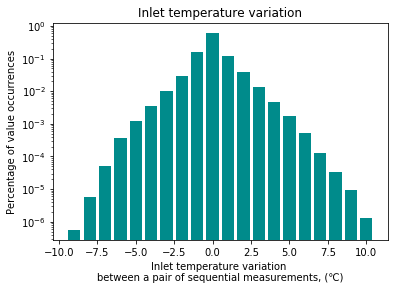

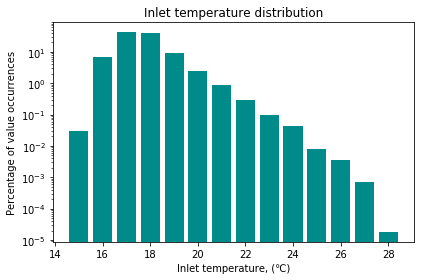

initialized


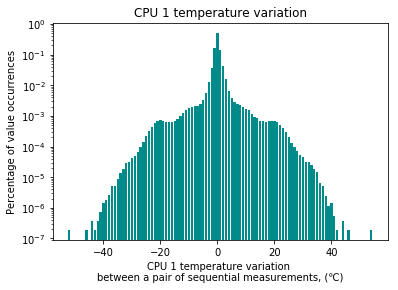

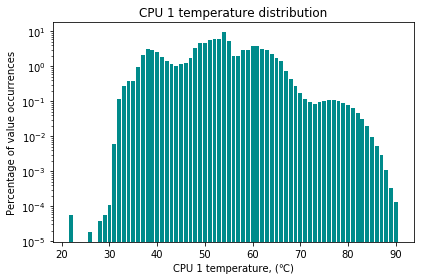

initialized


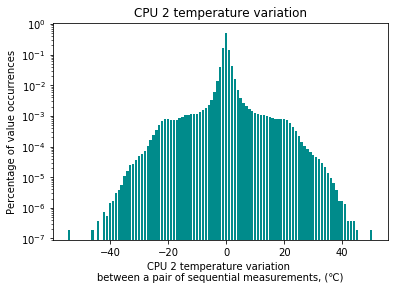

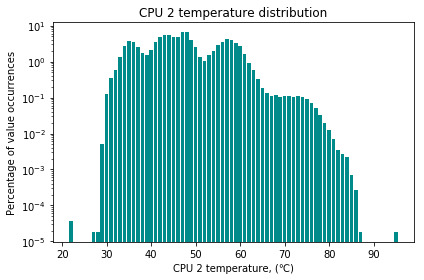

In [7]:
# Same for the whole year
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']

for temp_type, temp_title in zip(temp_types[1:], temp_titles[1:]):
    for df_name in nodes_df_names:
        node_df = data_prep_df[df_name].copy()
        node_df = node_df[~ node_df.loc[:, temp_type+'_temp'+ _no_outliers].\
                            isin([0, np.nan, np.inf, -np.inf])]
        
        counter_distrib_one_month  = collections.Counter(node_df.loc[:, temp_type+'_temp'].dropna())
        counter_variance_one_month = collections.Counter(node_df.loc[:, temp_type+'_temp_variation'].dropna())  
        
        if (df_name == nodes_df_names[0]):
#             print('initialized')
            counter_distrib = counter_distrib_one_month.copy()
            counter_variance = counter_variance_one_month.copy()
        else:
            counter_distrib  = counter_distrib + counter_distrib_one_month
            counter_variance = counter_variance + counter_variance_one_month
    #-------------------------------------------------
    fig, ax = plt.subplots()
    plt.title(temp_title+' temperature variation')
    keys, values = zip(*sorted(zip([*counter_variance.keys()],[*counter_variance.values()])))
    values = values / np.float64(sum(values))
    plt.bar(keys, values, color='darkcyan')
    plt.yscale('log')
    plt.ylabel('Percentage of value occurrences')
    plt.xlabel(temp_title+' temperature variation \nbetween a pair of sequential measurements, (℃)')
    plt.show()
    fig.savefig( os.path.join( Plots_dir, temp_title+'_temp_variation_distribution.png'),dpi=900)

    #-------------------------------------------------
    fig, ax = plt.subplots()
    plt.title(temp_title+' temperature distribution')
    keys, values = zip(*sorted(zip([*counter_distrib.keys()],[*counter_distrib.values()])))
    values = values / np.float64(sum(values)) * 100.0
    plt.bar(keys, values, color='darkcyan')
    plt.yscale('log')
    plt.ylabel('Percentage of value occurrences')
    plt.xlabel(temp_title+' temperature, (℃)')
    plt.tight_layout()
    plt.show()
    fig.savefig( os.path.join( Plots_dir, temp_title+'_temp_distribution.png'),dpi=900 )

## Available dates - improve the legend

In [157]:
import calendar
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

def plot_calendar(days, months, plot_name):
    plt.figure(figsize=(9, 3))
    # non days are grayed
    ax = plt.gca().axes
    ax.add_patch(Rectangle((29, 2), width=.8, height=.8, 
                           color='gray', alpha=.3))
    ax.add_patch(Rectangle((30, 2), width=.8, height=.8,
                           color='gray', alpha=.5))
    ax.add_patch(Rectangle((31, 2), width=.8, height=.8,
                           color='gray', alpha=.5))
    ax.add_patch(Rectangle((31, 4), width=.8, height=.8,
                           color='gray', alpha=.5))
    ax.add_patch(Rectangle((31, 6), width=.8, height=.8,
                           color='gray', alpha=.5))
    ax.add_patch(Rectangle((31, 9), width=.8, height=.8,
                           color='gray', alpha=.5))
    ax.add_patch(Rectangle((31, 11), width=.8, height=.8,
                           color='gray', alpha=.5))
    for d, m in zip(days, months):
        ax.add_patch(Rectangle((d, m), 
                               width=.8, height=.8, color='C0'))
    plt.yticks(np.arange(1, 13)+.5, list(calendar.month_abbr)[1:])
    plt.xticks(np.arange(1,32)+.5, np.arange(1,32))
    plt.xlim(1, 32)
    plt.ylim(1, 13)
    plt.gca().invert_yaxis()
    # remove borders and ticks
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tick_params(top=False, bottom=False, left=False, right=False)
    plt.tight_layout()
    plt.savefig( os.path.join( Plots_dir, plot_name + '.png'), dpi=900 )
    plt.show()

In [143]:
days = []
months = []
month_no = 5
for df_name in nodes_df_names:
    dates_one_month = data_prep_df[df_name].timestamp_py
    days_one_month = dates_one_month.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date().day)
    days = days + days_one_month.unique().tolist()
    months = months + ( np.ones(len(days_one_month.unique()), dtype=np.int16)*month_no ).tolist()
    month_no += 1
    if month_no == 8:
        month_no += 1
    elif month_no == 13:
        month_no = 1

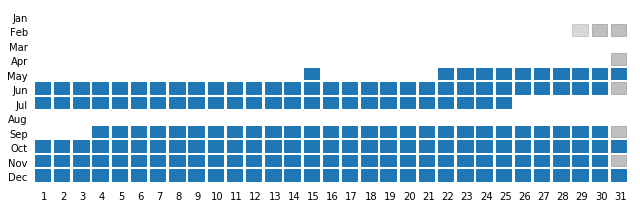

In [162]:
months_2018 = [i for i in months if i > 4]
plot_calendar(days[:len(months_2018)], months_2018, 'days_2018')

In [ ]:
plt.figure(figsize=(9, 3))
# non days are grayed
ax = plt.gca().axes
ax.add_patch(Rectangle((29, 2), width=.8, height=.8, 
                       color='gray', alpha=.3))
ax.add_patch(Rectangle((30, 2), width=.8, height=.8,
                       color='gray', alpha=.5))
ax.add_patch(Rectangle((31, 2), width=.8, height=.8,
                       color='gray', alpha=.5))
ax.add_patch(Rectangle((31, 4), width=.8, height=.8,
                       color='gray', alpha=.5))
ax.add_patch(Rectangle((31, 6), width=.8, height=.8,
                       color='gray', alpha=.5))
ax.add_patch(Rectangle((31, 9), width=.8, height=.8,
                       color='gray', alpha=.5))
ax.add_patch(Rectangle((31, 11), width=.8, height=.8,
                       color='gray', alpha=.5))
for d, m in zip(days, months):
    ax.add_patch(Rectangle((d, m), 
                           width=.8, height=.8, color='C0'))
plt.yticks(np.arange(1, 13)+.5, list(calendar.month_abbr)[1:])
plt.xticks(np.arange(1,32)+.5, np.arange(1,32))
plt.xlim(1, 32)
plt.ylim(1, 13)
plt.gca().invert_yaxis()
# remove borders and ticks
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False)
plt.tight_layout()
plt.savefig( os.path.join( Plots_dir, plot_name + '.png'), dpi=900 )
plt.show()

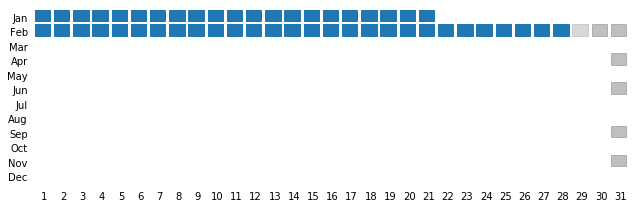

In [163]:
plot_calendar(days[len(months_2018):], months[len(months_2018):], 'days_2019')

# Hypotheses check-up

### Node 3, monthly graph of exhaust temperature vs inlet teperature

In [6]:
# for file_name, df_name in zip(nodes_file_names, nodes_df_names):
#     node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
#     p_exh = plt.plot('timestamp_measure', 'exh_temp', \
#                      data=node_df[node_df.nodename=='cresco6x003'], \
#                      label='Exhaust temp', color='firebrick')
#     p_inlet = plt.plot('timestamp_measure', 'amb_temp', \
#                        data=node_df[node_df.nodename=='cresco6x003'], \
#                        label='Inlet temp', color='steelblue')
#     month, year = extract_mm_YYYY(df_name)
#     plt.title(month + ' ' + year)
#     plt.legend()
# #     p_cpu1 = plt.plot('timestamp_measure', 'cpu1_temp', data=node_df, label='CPU1 temp')
# #     p_cpu2 = plt.plot('timestamp_measure', 'cpu2_temp', data=node_df, label='CPU2 temp')
#     plt.show()

###  Node 3, monthly difference between exhaust and inlet temperature

In [7]:
# data=node_df[node_df.nodename=='cresco6x003']
# for file_name, df_name in zip(nodes_file_names, nodes_df_names):
#     node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
#     p_exh = plt.plot(data.timestamp_measure, data.exh_temp - data.amb_temp, )
#     month, year = extract_mm_YYYY(df_name)
#     plt.title('(Exhaust - inlet) temperature ' + month + ' ' + year)
#     plt.legend()
#     plt.show()

###  Node 3, monthly difference between exhaust and inlet temperature
### Scatterplot representation

In [8]:
# for file_name, df_name in zip(nodes_file_names, nodes_df_names):
#     node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
#     p_exh_vs_inlet = plt.plot(data.amb_temp, data.exh_temp, 'o', color='darkred' )
#     month, year = extract_mm_YYYY(df_name)
#     plt.title('Exhaust vs inlet temperature\n' + month + ' ' + year)
#     plt.xlabel('Inlet temperature')
#     plt.ylabel('Exhaust temperature')
#     plt.tight_layout()
#     plt.show()

## Temperature, fans speed and CPU power trends - September

In [87]:
nodes_stats_Sept = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_September2018.csv'), \
                                         delimiter=";", header=0, index_col=0)
to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :] > 5.)[0]))
to_drop = nodes_stats_Sept.iloc[:,to_drop_ix].columns.values
node_df_Sept = pd.read_csv(os.path.join( Data_prep_dir, 'September2018.csv'), \
                                         delimiter=";", header=0)
for node in to_drop:
    node_df_Sept.drop(index=node_df_Sept[node_df_Sept.nodename == node].index)

### CPU power vs exhaust temperature

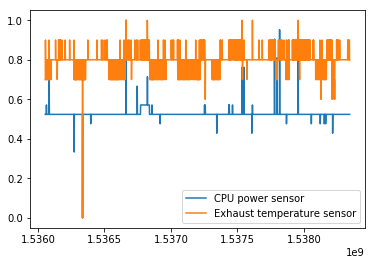

In [88]:
node_Sept_norm = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]].copy()

# node_Sept_norm.loc[:,['cpu_power', 'exh_temp']] = \
#     preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0)

node_Sept_norm.loc[:, ['cpu_power', 'cpu1_temp', 'cpu2_temp', 'exh_temp']] = \
    preprocessing.normalize(node_Sept_norm.loc[:, ['cpu_power','cpu1_temp', 'cpu2_temp', 'exh_temp']], norm='max', axis=0)
node_Sept_norm.exh_temp = round(node_Sept_norm.exh_temp, 1)
# plt.plot('timestamp_measure', \
#          preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0))
plt.plot('timestamp_measure','cpu_power', data=node_Sept_norm, label='CPU power sensor')
plt.plot('timestamp_measure','exh_temp', data=node_Sept_norm, label='Exhaust temperature sensor')
plt.legend()
plt.show()

In [75]:
# plt.plot('timestamp_measure','cpu_power', data=node_Sept_norm, label='CPU power sensor')
# plt.show()

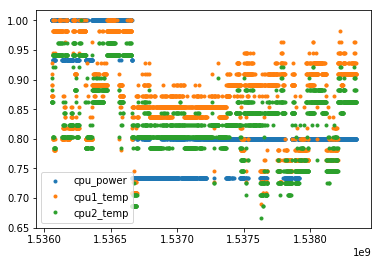

In [9]:
plt.plot('timestamp_measure', 'cpu_power', data=node_Sept_norm, label='cpu_power', linestyle='', marker='.')
plt.plot('timestamp_measure', 'cpu1_temp', data=node_Sept_norm, label='cpu1_temp', linestyle='', marker='.')
plt.plot('timestamp_measure', 'cpu2_temp', data=node_Sept_norm, label='cpu2_temp', linestyle='', marker='.')
plt.legend()
plt.show()

## Fans

In [80]:
# plt.plot('timestamp_measure', 'fan1a', data=node_Sept_norm, label='fan1a')
# plt.plot('timestamp_measure', 'fan2a', data=node_Sept_norm, label='fan2a')
# plt.plot('timestamp_measure', 'fan3a', data=node_Sept_norm, label='fan3a')
# plt.legend()
# plt.show()

In [79]:
# plt.plot('timestamp_measure', 'fan1a', data=node_Sept, label='fan1a')
# plt.plot('timestamp_measure', 'fan1b', data=node_Sept, label='fan1b')
# plt.legend()
# plt.show()

In [78]:
# plt.plot('timestamp_measure', 'fan2a', data=node_Sept, label='fan2a')
# plt.plot('timestamp_measure', 'fan2b', data=node_Sept, label='fan2b')
# plt.legend()
# plt.show()

In [77]:
# plt.plot('timestamp_measure', 'fan3a', data=node_Sept, label='fan3a')
# plt.plot('timestamp_measure', 'fan3b', data=node_Sept, label='fan3b')
# plt.legend()
# plt.show()

## Distance between CPU temperature and CPU power utilization

In [76]:
# plt.plot(abs(node_Sept_norm.cpu_power[:] - node_Sept_norm.cpu1_temp[:]).values, \
#          linestyle='-', marker='.')
# plt.title('Dist(CPU_power, CPU1_temp)')
# plt.legend()
# plt.show()

# plt.plot(abs(node_Sept_norm.cpu_power - node_Sept_norm.exh_temp).values, \
#          linestyle='-', marker='.')
# plt.title('Dist(CPU_power, exhaust_temp)')
# plt.legend()
# plt.show()

# Resume
- no obvious correlation 
        - between fans speed
        - between CPU temperature and CPU power utilization
        - between exhaust temperature and CPU power utilization
(more analysis required)

----
Started analysis of thermal data:
- temperature drop graph for node 3 (the node with all the data present for all months)
- exhaust and inlet temperature of the node
    - line graph
    - scatter plot

----

Graphs finalized, all in two versions, one with dcenergy measurements as primary source, another with integral of sys_power measurements (in this case data is present for all the nodes):
- portions of energy consumed by CPU, memory and other equipment
    - for each month
    - avg for all months
- monthly energy consumption by node, nodes are sorted in the increasing order of energy consumption
- energy consumed by the cluster
    - for each month
    - total sum for all months taking into account all nodes of the cluster 